## TIES relative binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the TIES application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [5]:
# input parameters
params = pd.read_csv('./data_ties/ties_inputs.csv')
param_names = params.keys()
params = params.values

n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_min = np.min(params, axis=0)
p_max = np.max(params, axis=0)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

In [6]:
print('There are %d inputs' % D)

There are 169 inputs


### Load output samples

Load the corresponding Monte Carlo outputs, in the case the relative binding free energy predictions.

In [7]:
QoI = 'relative_binding_energy'
output = pd.read_csv('./data_ties/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [8]:
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 2].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [9]:
########################################
# choose the active subspace dimension #
########################################
d = 1

### Hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 100
# number of hidden layer + output layer
n_layers = 3

n_neurons = [d]
for i in range(n_layers-1): n_neurons.append(n_hidden_neurons)

# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network



In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        W_1 = das_surrogate.neural_net.layers[1].W
        results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        # results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [15]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 302.12it/s]


 loss = 0.3390
Relative training error = 65.5838 %
Relative test error = 62.2638 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1247


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.20it/s]


Relative training error = 57.0115 %
Relative test error = 60.1171 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.82it/s]


Relative training error = 50.8989 %
Relative test error = 62.2085 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.30it/s]


Relative training error = 45.1862 %
Relative test error = 64.6871 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3494


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.78it/s]


Relative training error = 41.0769 %
Relative test error = 59.2009 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 332.72it/s]


Relative training error = 37.1895 %
Relative test error = 61.2370 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.94it/s]


Relative training error = 34.6129 %
Relative test error = 52.6718 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.01it/s]


 loss = 0.3657
Relative training error = 31.2015 %
Relative test error = 52.9105 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.24it/s]


Relative training error = 28.9221 %
Relative test error = 47.4208 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2370


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 332.99it/s]


Relative training error = 28.0885 %
Relative test error = 42.7046 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 299.36it/s]


 loss = 0.0897
Relative training error = 26.1239 %
Relative test error = 41.7602 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 332.22it/s]

 loss = 0.1787
Relative training error = 24.7995 %


Relative test error = 41.7294 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.75it/s]


 loss = 0.0940
Relative training error = 23.7511 %
Relative test error = 39.6774 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.61it/s]


Relative training error = 23.2801 %
Relative test error = 37.4437 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0728


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.33it/s]


Relative training error = 22.6803 %
Relative test error = 36.5990 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0858


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.74it/s]


Relative training error = 22.0832 %
Relative test error = 36.1516 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1127


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.45it/s]


Relative training error = 21.4478 %
Relative test error = 35.5849 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.24it/s]

 loss = 0.1118


Relative training error = 21.0164 %
Relative test error = 34.4548 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.13it/s]

 loss = 0.2061


Relative training error = 20.6611 %
Relative test error = 34.3335 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.63it/s]


Relative training error = 20.2682 %
Relative test error = 33.8977 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 337.44it/s]


Relative training error = 19.9082 %
Relative test error = 33.2591 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 330.97it/s]


Relative training error = 19.6484 %
Relative test error = 32.9213 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.37it/s]


Relative training error = 19.5955 %
Relative test error = 32.5408 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.65it/s]


Relative training error = 19.3072 %
Relative test error = 31.9352 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.97it/s]


Relative training error = 18.8716 %
Relative test error = 32.5115 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 338.12it/s]


 loss = 0.0909
Relative training error = 18.7666 %
Relative test error = 33.5226 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.61it/s]


 loss = 0.0569
Relative training error = 18.8638 %
Relative test error = 33.2961 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1070


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.00it/s]


Relative training error = 18.6679 %
Relative test error = 31.3997 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.49it/s]


Relative training error = 18.6591 %
Relative test error = 31.4930 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.21it/s]


 loss = 0.1144
Relative training error = 19.0958 %
Relative test error = 31.9946 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0864


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.58it/s]


Relative training error = 18.5929 %
Relative test error = 31.4075 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.11it/s]


Relative training error = 17.9648 %
Relative test error = 30.9476 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.77it/s]


Relative training error = 17.9840 %
Relative test error = 31.4229 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0820


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.38it/s]


Relative training error = 17.9556 %
Relative test error = 30.9603 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0639


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.98it/s]


Relative training error = 18.2203 %
Relative test error = 31.0283 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.91it/s]


Relative training error = 17.9264 %
Relative test error = 31.1016 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.88it/s]


Relative training error = 17.8479 %
Relative test error = 31.3585 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.27it/s]


Relative training error = 17.7347 %
Relative test error = 31.2671 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.67it/s]


 loss = 0.9998
Relative training error = 63.9721 %
Relative test error = 67.1901 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.9536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.27it/s]


Relative training error = 57.1073 %
Relative test error = 66.6385 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.86it/s]


Relative training error = 46.4233 %
Relative test error = 70.7145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.92it/s]


 loss = 0.3149
Relative training error = 40.8313 %
Relative test error = 69.6169 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.71it/s]


Relative training error = 37.2610 %
Relative test error = 64.9353 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.97it/s]


Relative training error = 33.7721 %
Relative test error = 62.4593 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.51it/s]


Relative training error = 31.8089 %
Relative test error = 58.0354 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.38it/s]


Relative training error = 29.8530 %
Relative test error = 54.7674 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.96it/s]


Relative training error = 28.6321 %
Relative test error = 52.3255 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.23it/s]


Relative training error = 27.4115 %
Relative test error = 49.3434 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.58it/s]


Relative training error = 26.2135 %
Relative test error = 47.9011 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2292


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.64it/s]


Relative training error = 25.0664 %
Relative test error = 44.3594 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.83it/s]


Relative training error = 25.5249 %
Relative test error = 43.5089 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.08it/s]


Relative training error = 23.3754 %
Relative test error = 41.5337 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.73it/s]


Relative training error = 22.5256 %
Relative test error = 41.0020 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 334.61it/s]


Relative training error = 21.8674 %
Relative test error = 40.3077 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1546


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.36it/s]


Relative training error = 21.5419 %
Relative test error = 39.0557 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0831


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.81it/s]


Relative training error = 20.6749 %
Relative test error = 38.1261 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.79it/s]


Relative training error = 20.6214 %
Relative test error = 37.6014 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.52it/s]


Relative training error = 20.2216 %
Relative test error = 36.9293 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.90it/s]


Relative training error = 19.9278 %
Relative test error = 35.6676 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0745


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.34it/s]


Relative training error = 20.1492 %
Relative test error = 35.4762 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.62it/s]


Relative training error = 19.0596 %
Relative test error = 34.8519 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0437


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.60it/s]


Relative training error = 18.8064 %
Relative test error = 35.0837 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.44it/s]


Relative training error = 18.6541 %
Relative test error = 36.4890 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.73it/s]


Relative training error = 18.2879 %
Relative test error = 36.8387 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.82it/s]


 loss = 0.0964
Relative training error = 17.9785 %
Relative test error = 36.3261 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.9078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.73it/s]


Relative training error = 61.5158 %
Relative test error = 60.5994 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.68it/s]


 loss = 0.7836
Relative training error = 59.2879 %
Relative test error = 61.6529 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.63it/s]


Relative training error = 54.9430 %
Relative test error = 62.7835 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2790


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.58it/s]


Relative training error = 48.9536 %
Relative test error = 62.0016 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.87it/s]


Relative training error = 42.5790 %
Relative test error = 59.9691 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.94it/s]


Relative training error = 37.6295 %
Relative test error = 60.3145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.03it/s]


 loss = 0.3644
Relative training error = 34.8541 %
Relative test error = 56.4311 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.32it/s]


Relative training error = 31.8129 %
Relative test error = 53.4826 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.10it/s]


Relative training error = 29.5827 %
Relative test error = 47.8084 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.95it/s]


Relative training error = 27.8463 %
Relative test error = 44.2904 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1677


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.63it/s]


Relative training error = 26.6885 %
Relative test error = 43.8261 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.67it/s]


Relative training error = 25.2083 %
Relative test error = 41.4000 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1029


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.44it/s]


Relative training error = 24.3642 %
Relative test error = 38.9998 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0780


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.27it/s]


Relative training error = 23.6710 %
Relative test error = 39.0668 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0882


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.90it/s]


Relative training error = 22.9932 %
Relative test error = 39.0721 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.79it/s]


 loss = 0.0557
Relative training error = 22.3330 %
Relative test error = 38.5603 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.08it/s]

 loss = 0.0724


Relative training error = 21.8572 %
Relative test error = 38.1969 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.73it/s]


Relative training error = 21.1997 %
Relative test error = 38.3699 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.34it/s]


Relative training error = 20.8493 %
Relative test error = 38.0866 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.55it/s]


Relative training error = 20.4206 %
Relative test error = 38.6660 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.56it/s]


Relative training error = 20.2515 %
Relative test error = 37.0425 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.50it/s]


Relative training error = 19.6047 %
Relative test error = 36.9873 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.94it/s]


Relative training error = 19.3541 %
Relative test error = 36.0398 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.68it/s]

 loss = 0.1485


Relative training error = 19.1170 %
Relative test error = 36.5046 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.49it/s]

 loss = 0.0572


Relative training error = 18.7886 %
Relative test error = 36.0035 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0901


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.98it/s]


Relative training error = 18.5134 %
Relative test error = 35.0210 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.40it/s]


Relative training error = 18.5486 %
Relative test error = 34.4964 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.10it/s]


Relative training error = 18.2468 %
Relative test error = 34.0249 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.95it/s]


Relative training error = 18.0157 %
Relative test error = 34.1731 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0901


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.96it/s]


Relative training error = 18.0736 %
Relative test error = 33.6989 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.01it/s]


Relative training error = 17.6655 %
Relative test error = 34.2738 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1002


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.42it/s]


Relative training error = 17.7050 %
Relative test error = 33.7173 %


 loss = 0.0835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.07it/s]


Relative training error = 17.3365 %
Relative test error = 33.3054 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0285


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.96it/s]


Relative training error = 17.7190 %
Relative test error = 33.4168 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0801


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.59it/s]


Relative training error = 17.3712 %
Relative test error = 32.7671 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.93it/s]


Relative training error = 17.4027 %
Relative test error = 33.2238 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.66it/s]


Relative training error = 17.0567 %
Relative test error = 32.6089 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0803


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.13it/s]


Relative training error = 16.9815 %
Relative test error = 32.1980 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.79it/s]


Relative training error = 16.8690 %
Relative test error = 32.3308 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.91it/s]


Relative training error = 16.7838 %
Relative test error = 32.1324 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0564


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.78it/s]


Relative training error = 16.7679 %
Relative test error = 32.4734 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.34it/s]


Relative training error = 17.5419 %
Relative test error = 33.5596 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.36it/s]


Relative training error = 16.6819 %
Relative test error = 32.8094 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.70it/s]


Relative training error = 16.5667 %
Relative test error = 32.6334 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.14it/s]

 loss = 0.1068


Relative training error = 16.6004 %
Relative test error = 32.8660 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.32it/s]

 loss = 0.1644


Relative training error = 16.5377 %
Relative test error = 32.9131 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.43it/s]

 loss = 0.0550


Relative training error = 16.4848 %
Relative test error = 33.6857 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.62it/s]

 loss = 0.0705


Relative training error = 16.4345 %
Relative test error = 33.5876 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 3.4125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.05it/s]


Relative training error = 64.5849 %
Relative test error = 62.4866 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.62it/s]


Relative training error = 62.3323 %
Relative test error = 67.4103 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5826


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.48it/s]


Relative training error = 59.7058 %
Relative test error = 63.0209 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.44it/s]


Relative training error = 58.7432 %
Relative test error = 66.1051 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.86it/s]


Relative training error = 56.4522 %
Relative test error = 67.9888 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.67it/s]


Relative training error = 51.2266 %
Relative test error = 65.4851 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.12it/s]

 loss = 0.5721


Relative training error = 46.9925 %
Relative test error = 70.7297 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.88it/s]


Relative training error = 42.5465 %
Relative test error = 67.3730 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7721


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.39it/s]


Relative training error = 39.2957 %
Relative test error = 63.2808 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.91it/s]


Relative training error = 36.4514 %
Relative test error = 62.2197 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.01it/s]


Relative training error = 33.7992 %
Relative test error = 58.1668 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.56it/s]


Relative training error = 31.9364 %
Relative test error = 55.7624 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.99it/s]


Relative training error = 30.1404 %
Relative test error = 52.2125 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.16it/s]


Relative training error = 28.9534 %
Relative test error = 48.4420 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1419


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.47it/s]


Relative training error = 27.7243 %
Relative test error = 45.6454 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.44it/s]


Relative training error = 26.6296 %
Relative test error = 42.7068 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.73it/s]

 loss = 0.1869


Relative training error = 26.8544 %
Relative test error = 42.9978 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.70it/s]

 loss = 0.2066


Relative training error = 25.7771 %
Relative test error = 39.2724 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.43it/s]

 loss = 0.3392


Relative training error = 24.1484 %
Relative test error = 38.5499 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.36it/s]


Relative training error = 23.7458 %
Relative test error = 37.8021 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1572


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.94it/s]


Relative training error = 22.7443 %
Relative test error = 36.9938 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1913


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.52it/s]


Relative training error = 22.4205 %
Relative test error = 37.2194 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1230


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.15it/s]


Relative training error = 22.1896 %
Relative test error = 35.9235 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.84it/s]


Relative training error = 21.7915 %
Relative test error = 34.7791 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.34it/s]


Relative training error = 21.4605 %
Relative test error = 34.4476 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.50it/s]


Relative training error = 20.7444 %
Relative test error = 34.0459 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0784


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.42it/s]


Relative training error = 20.4177 %
Relative test error = 34.3140 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.52it/s]


Relative training error = 20.0606 %
Relative test error = 34.8398 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0520


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.62it/s]


Relative training error = 19.9024 %
Relative test error = 34.5131 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1464


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.53it/s]


Relative training error = 19.7023 %
Relative test error = 33.2859 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0745


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.91it/s]


Relative training error = 19.5666 %
Relative test error = 34.5594 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.28it/s]


Relative training error = 19.1814 %
Relative test error = 33.8385 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.53it/s]


Relative training error = 18.9957 %
Relative test error = 33.5553 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.35it/s]


Relative training error = 19.2751 %
Relative test error = 33.5601 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.46it/s]


Relative training error = 18.7985 %
Relative test error = 33.1778 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.92it/s]


Relative training error = 18.8648 %
Relative test error = 31.8349 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.46it/s]


Relative training error = 18.9123 %
Relative test error = 32.6581 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0967


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.63it/s]


Relative training error = 18.2722 %
Relative test error = 31.9698 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.52it/s]


Relative training error = 18.2502 %
Relative test error = 31.6759 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 228.63it/s]


Relative training error = 18.0696 %
Relative test error = 31.6897 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.78it/s]

 loss = 0.0457
Relative training error = 17.8937 %


Relative test error = 31.6021 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.96it/s]


 loss = 0.0637
Relative training error = 17.8083 %
Relative test error = 31.5778 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1009


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.15it/s]


Relative training error = 17.8546 %
Relative test error = 32.6786 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 4.0480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 304.12it/s]


Relative training error = 64.1719 %
Relative test error = 61.6405 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.22it/s]


Relative training error = 64.6766 %
Relative test error = 62.3030 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.91it/s]


Relative training error = 61.7205 %
Relative test error = 60.5239 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.21it/s]


Relative training error = 59.1414 %
Relative test error = 62.2352 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3749


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.72it/s]


Relative training error = 55.1744 %
Relative test error = 61.1790 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.21it/s]


Relative training error = 51.1529 %
Relative test error = 62.6274 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.11it/s]


Relative training error = 45.6951 %
Relative test error = 62.5840 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.18it/s]


Relative training error = 40.5068 %
Relative test error = 56.5514 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.54it/s]


Relative training error = 36.6569 %
Relative test error = 54.9206 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.76it/s]


Relative training error = 33.6288 %
Relative test error = 50.1255 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.15it/s]


Relative training error = 32.5579 %
Relative test error = 47.1611 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4685


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.67it/s]


Relative training error = 30.6482 %
Relative test error = 45.0776 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.93it/s]


Relative training error = 29.4298 %
Relative test error = 44.2653 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.32it/s]


Relative training error = 28.2611 %
Relative test error = 39.9923 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.67it/s]


Relative training error = 27.9341 %
Relative test error = 38.9391 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.69it/s]

 loss = 0.2336


Relative training error = 26.6122 %
Relative test error = 38.8490 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.30it/s]


Relative training error = 25.3607 %
Relative test error = 37.5404 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.30it/s]


Relative training error = 24.6332 %
Relative test error = 36.1682 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.63it/s]


Relative training error = 23.9935 %
Relative test error = 35.9397 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.84it/s]


Relative training error = 23.1536 %
Relative test error = 33.8969 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.77it/s]


Relative training error = 22.7779 %
Relative test error = 34.1881 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.97it/s]


Relative training error = 22.2401 %
Relative test error = 33.1265 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.33it/s]


Relative training error = 22.3331 %
Relative test error = 32.9880 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1008


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.03it/s]


Relative training error = 21.8473 %
Relative test error = 32.0651 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.82it/s]


Relative training error = 20.9396 %
Relative test error = 31.7167 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.06it/s]


Relative training error = 20.8445 %
Relative test error = 31.6308 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 487.90it/s]


Relative training error = 20.3915 %
Relative test error = 32.2150 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.01it/s]

 loss = 0.0892


Relative training error = 20.8095 %
Relative test error = 31.0237 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.07it/s]


Relative training error = 20.0450 %
Relative test error = 31.2721 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.81it/s]


Relative training error = 19.7290 %
Relative test error = 32.7280 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.44it/s]

 loss = 0.1744


Relative training error = 19.5378 %
Relative test error = 32.6015 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.81it/s]


Relative training error = 19.4294 %
Relative test error = 32.0793 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.29it/s]


Relative training error = 19.1848 %
Relative test error = 32.2754 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.15it/s]


Relative training error = 18.9050 %
Relative test error = 31.7636 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.36it/s]


Relative training error = 18.8428 %
Relative test error = 31.1519 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.42it/s]


Relative training error = 19.3153 %
Relative test error = 30.9737 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.11it/s]


Relative training error = 18.7506 %
Relative test error = 31.2793 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.73it/s]


Relative training error = 18.4334 %
Relative test error = 30.5515 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.19it/s]


Relative training error = 18.3324 %
Relative test error = 29.7726 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.83it/s]


Relative training error = 18.2982 %
Relative test error = 31.0174 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0638


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.54it/s]


Relative training error = 18.2860 %
Relative test error = 31.6495 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.10it/s]


Relative training error = 18.2544 %
Relative test error = 31.3649 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.19it/s]


Relative training error = 18.2851 %
Relative test error = 31.5931 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.58it/s]


Relative training error = 18.0009 %
Relative test error = 31.0696 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 318.92it/s]


Relative training error = 18.0114 %
Relative test error = 30.6320 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.46it/s]


Relative training error = 17.7153 %
Relative test error = 31.4711 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1219


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.38it/s]


Relative training error = 17.7347 %
Relative test error = 32.3716 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1110


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.94it/s]


Relative training error = 17.6004 %
Relative test error = 32.2698 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.77it/s]


Relative training error = 17.4035 %
Relative test error = 32.4207 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.29it/s]


Relative training error = 17.7227 %
Relative test error = 31.4764 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.78it/s]


Relative training error = 17.3649 %
Relative test error = 31.0275 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.20it/s]


Relative training error = 17.6469 %
Relative test error = 31.4995 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.39it/s]


Relative training error = 17.1723 %
Relative test error = 31.4472 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.48it/s]


Relative training error = 17.1543 %
Relative test error = 32.0028 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.87it/s]


Relative training error = 17.1926 %
Relative test error = 32.5038 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.9492


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.36it/s]


Relative training error = 64.8186 %
Relative test error = 66.0084 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.78it/s]


Relative training error = 52.8981 %
Relative test error = 63.7553 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.8452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.31it/s]


Relative training error = 47.5842 %
Relative test error = 60.0965 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.77it/s]


Relative training error = 41.7063 %
Relative test error = 59.6538 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.09it/s]


Relative training error = 38.1844 %
Relative test error = 56.6093 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.12it/s]


Relative training error = 35.0967 %
Relative test error = 54.0935 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2441


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.24it/s]


Relative training error = 32.9922 %
Relative test error = 49.7943 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1521


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.81it/s]


Relative training error = 30.9634 %
Relative test error = 48.5946 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 347.67it/s]


Relative training error = 29.2451 %
Relative test error = 46.0605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.15it/s]


Relative training error = 28.0619 %
Relative test error = 43.7781 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.89it/s]


 loss = 0.2019
Relative training error = 26.9460 %
Relative test error = 41.9066 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.89it/s]


Relative training error = 25.6800 %
Relative test error = 39.9105 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.30it/s]


Relative training error = 24.6945 %
Relative test error = 39.2291 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.11it/s]


Relative training error = 24.3892 %
Relative test error = 39.0834 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.75it/s]


Relative training error = 23.3900 %
Relative test error = 38.1432 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.99it/s]


Relative training error = 22.7047 %
Relative test error = 37.2900 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1175


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.46it/s]


Relative training error = 22.4325 %
Relative test error = 37.2397 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1830


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.30it/s]


Relative training error = 21.8171 %
Relative test error = 36.0136 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.66it/s]


Relative training error = 21.2309 %
Relative test error = 34.8128 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.10it/s]


Relative training error = 20.8440 %
Relative test error = 34.6438 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.68it/s]


Relative training error = 20.6992 %
Relative test error = 34.0509 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.27it/s]


Relative training error = 20.1336 %
Relative test error = 33.8199 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.91it/s]


Relative training error = 19.7821 %
Relative test error = 32.4522 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.62it/s]


Relative training error = 19.6887 %
Relative test error = 32.2012 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1470


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.43it/s]


Relative training error = 19.3392 %
Relative test error = 31.9192 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 277.50it/s]


Relative training error = 19.3092 %
Relative test error = 31.3246 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.55it/s]


Relative training error = 18.9123 %
Relative test error = 30.5802 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.12it/s]


Relative training error = 18.7249 %
Relative test error = 31.0932 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.08it/s]


Relative training error = 18.4415 %
Relative test error = 31.3125 %


 loss = 0.0891


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 334.31it/s]


Relative training error = 18.4173 %
Relative test error = 31.8176 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 316.96it/s]


Relative training error = 18.5973 %
Relative test error = 31.5804 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.36it/s]


 loss = 0.6903
Relative training error = 63.5031 %
Relative test error = 60.8959 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.90it/s]

 loss = 1.0418


Relative training error = 61.5863 %
Relative test error = 59.4529 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.59it/s]


 loss = 0.7111
Relative training error = 59.5444 %
Relative test error = 59.1602 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.59it/s]


 loss = 0.4562
Relative training error = 50.8120 %
Relative test error = 57.5156 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.44it/s]


Relative training error = 43.0208 %
Relative test error = 53.8984 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4620


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.41it/s]


Relative training error = 37.7979 %
Relative test error = 51.1853 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 327.54it/s]


Relative training error = 34.4006 %
Relative test error = 49.9361 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.19it/s]


Relative training error = 30.5704 %
Relative test error = 47.4221 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.65it/s]


Relative training error = 28.2629 %
Relative test error = 42.2547 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.61it/s]


Relative training error = 26.4126 %
Relative test error = 40.4559 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2458


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.06it/s]


Relative training error = 25.3740 %
Relative test error = 39.8454 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.30it/s]


Relative training error = 23.8906 %
Relative test error = 36.0866 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.78it/s]


Relative training error = 23.4842 %
Relative test error = 35.1658 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.93it/s]


Relative training error = 22.1580 %
Relative test error = 34.1924 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.50it/s]


Relative training error = 21.5988 %
Relative test error = 34.1261 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.58it/s]


Relative training error = 21.6146 %
Relative test error = 32.9827 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.84it/s]


Relative training error = 20.9620 %
Relative test error = 33.2711 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.25it/s]


 loss = 0.0673
Relative training error = 20.5497 %
Relative test error = 30.8233 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.49it/s]


Relative training error = 20.0400 %
Relative test error = 30.8025 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 236.55it/s]


Relative training error = 19.9499 %
Relative test error = 31.6582 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.13it/s]


 loss = 0.1118
Relative training error = 20.1119 %
Relative test error = 30.9494 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.14it/s]


Relative training error = 19.3976 %
Relative test error = 30.9970 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0816


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.10it/s]


Relative training error = 19.3034 %
Relative test error = 30.5463 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.36it/s]


Relative training error = 19.0495 %
Relative test error = 30.3714 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.25it/s]


Relative training error = 19.3289 %
Relative test error = 30.6401 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.75it/s]


Relative training error = 18.5814 %
Relative test error = 30.1415 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0995


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.77it/s]


Relative training error = 19.5576 %
Relative test error = 31.2101 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.37it/s]


Relative training error = 18.7184 %
Relative test error = 30.4376 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.54it/s]


Relative training error = 18.1910 %
Relative test error = 30.2975 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.10it/s]


Relative training error = 18.3473 %
Relative test error = 29.9769 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.27it/s]


Relative training error = 17.9729 %
Relative test error = 28.8933 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.89it/s]


Relative training error = 17.8255 %
Relative test error = 29.2276 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.89it/s]


Relative training error = 17.9080 %
Relative test error = 30.1169 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.04it/s]


Relative training error = 18.0096 %
Relative test error = 29.7118 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.82it/s]


Relative training error = 18.0177 %
Relative test error = 29.1548 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.33it/s]


 loss = 0.0972
Relative training error = 17.9494 %
Relative test error = 28.9626 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.46it/s]

 loss = 0.0676


Relative training error = 17.7053 %
Relative test error = 28.7179 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.38it/s]


Relative training error = 17.4882 %
Relative test error = 27.5130 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0546


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.38it/s]


Relative training error = 17.7362 %
Relative test error = 28.8266 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.70it/s]


Relative training error = 17.9910 %
Relative test error = 28.9242 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.75it/s]


Relative training error = 17.1509 %
Relative test error = 28.2229 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.29it/s]

 loss = 0.0566


Relative training error = 17.1829 %
Relative test error = 28.1004 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.45it/s]


Relative training error = 17.2612 %
Relative test error = 28.1382 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.09it/s]

 loss = 0.0895


Relative training error = 17.2119 %
Relative test error = 28.9835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.83it/s]


 loss = 0.0698
Relative training error = 17.0866 %
Relative test error = 28.8464 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.84it/s]

 loss = 0.1255


Relative training error = 17.1217 %
Relative test error = 28.1947 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.38it/s]


Relative training error = 17.1530 %
Relative test error = 28.0799 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.09it/s]


Relative training error = 17.0774 %
Relative test error = 28.9150 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0976


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.76it/s]


Relative training error = 17.1825 %
Relative test error = 28.0635 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0620


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.97it/s]


Relative training error = 17.0949 %
Relative test error = 27.9882 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.50it/s]


Relative training error = 17.1877 %
Relative test error = 27.4252 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.05it/s]


Relative training error = 16.9255 %
Relative test error = 28.1186 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.08it/s]


Relative training error = 16.8010 %
Relative test error = 29.1002 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1002


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 275.01it/s]


Relative training error = 16.7251 %
Relative test error = 29.0342 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.93it/s]


Relative training error = 16.7315 %
Relative test error = 28.0075 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 5.1551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.66it/s]


Relative training error = 74.5305 %
Relative test error = 69.0886 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.17it/s]


Relative training error = 58.2653 %
Relative test error = 62.4167 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4287


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.32it/s]


Relative training error = 50.9248 %
Relative test error = 61.5501 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.15it/s]


Relative training error = 43.5310 %
Relative test error = 56.4570 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.53it/s]


Relative training error = 38.7253 %
Relative test error = 53.1929 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.30it/s]


Relative training error = 36.4720 %
Relative test error = 49.0393 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.33it/s]


Relative training error = 33.9895 %
Relative test error = 46.0599 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.16it/s]


Relative training error = 31.8393 %
Relative test error = 41.9066 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.10it/s]


Relative training error = 29.8861 %
Relative test error = 40.2441 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4196


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.81it/s]


Relative training error = 28.4744 %
Relative test error = 38.0515 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.71it/s]


Relative training error = 27.0053 %
Relative test error = 36.8082 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.26it/s]


Relative training error = 25.8102 %
Relative test error = 35.3643 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.77it/s]


Relative training error = 25.6315 %
Relative test error = 34.2827 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.68it/s]


Relative training error = 24.3548 %
Relative test error = 34.0490 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.85it/s]


Relative training error = 23.5837 %
Relative test error = 33.9726 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2825


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.09it/s]


Relative training error = 22.8677 %
Relative test error = 32.6252 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.78it/s]


Relative training error = 22.2261 %
Relative test error = 31.1448 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.92it/s]


Relative training error = 21.7030 %
Relative test error = 30.7880 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.28it/s]


Relative training error = 21.4053 %
Relative test error = 30.0615 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.60it/s]

 loss = 0.1167


Relative training error = 21.1598 %
Relative test error = 30.4559 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.16it/s]

 loss = 0.0790


Relative training error = 20.9170 %
Relative test error = 29.3655 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.15it/s]


Relative training error = 20.5644 %
Relative test error = 28.7625 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.06it/s]


Relative training error = 20.0502 %
Relative test error = 28.4112 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1722


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.68it/s]


Relative training error = 20.0837 %
Relative test error = 28.7037 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.19it/s]


 loss = 0.1471
Relative training error = 19.9259 %
Relative test error = 30.0350 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.19it/s]

 loss = 0.0474


Relative training error = 19.6568 %
Relative test error = 31.0390 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.92it/s]

 loss = 0.0788


Relative training error = 19.5573 %
Relative test error = 30.7249 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.1572


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.12it/s]


Relative training error = 68.9169 %
Relative test error = 66.3989 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.47it/s]

 loss = 1.1085


Relative training error = 59.3589 %
Relative test error = 65.4184 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.01it/s]

 loss = 0.7192


Relative training error = 52.4023 %
Relative test error = 69.2056 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.88it/s]

 loss = 0.5382


Relative training error = 44.2173 %
Relative test error = 60.4929 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.37it/s]

 loss = 0.6558


Relative training error = 39.1156 %
Relative test error = 59.5766 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.08it/s]

 loss = 0.4657


Relative training error = 35.1814 %
Relative test error = 54.0263 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.27it/s]


Relative training error = 32.2134 %
Relative test error = 48.2386 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.82it/s]


Relative training error = 30.0449 %
Relative test error = 46.6738 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.66it/s]

 loss = 0.1779


Relative training error = 28.4623 %
Relative test error = 43.5179 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.71it/s]

 loss = 0.3119


Relative training error = 27.2739 %
Relative test error = 42.0406 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.86it/s]

 loss = 0.1536


Relative training error = 25.4580 %
Relative test error = 40.4497 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.82it/s]


Relative training error = 24.3487 %
Relative test error = 37.9062 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.57it/s]


Relative training error = 23.3370 %
Relative test error = 37.3089 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.47it/s]


Relative training error = 22.4188 %
Relative test error = 35.6263 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.94it/s]


Relative training error = 21.8383 %
Relative test error = 35.7109 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1083


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.55it/s]


Relative training error = 21.2001 %
Relative test error = 34.9530 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1354


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.27it/s]


Relative training error = 20.7241 %
Relative test error = 33.8574 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.71it/s]


Relative training error = 20.2738 %
Relative test error = 33.7617 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.33it/s]


Relative training error = 19.8962 %
Relative test error = 34.2228 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0449


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.36it/s]


Relative training error = 19.6958 %
Relative test error = 34.0443 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.24it/s]


Relative training error = 19.4342 %
Relative test error = 34.0244 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.95it/s]


Relative training error = 19.0820 %
Relative test error = 33.1140 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.55it/s]


Relative training error = 18.7754 %
Relative test error = 32.3785 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.52it/s]


Relative training error = 18.2551 %
Relative test error = 32.2742 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0970


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.43it/s]


Relative training error = 18.8255 %
Relative test error = 32.3415 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.35it/s]


Relative training error = 18.1563 %
Relative test error = 31.0476 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.56it/s]


Relative training error = 17.9749 %
Relative test error = 30.3072 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 332.79it/s]


Relative training error = 18.2637 %
Relative test error = 30.9263 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.24it/s]


Relative training error = 17.8488 %
Relative test error = 29.7892 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.46it/s]


Relative training error = 17.6403 %
Relative test error = 29.3865 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0439


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 261.02it/s]


Relative training error = 17.6070 %
Relative test error = 29.3274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.64it/s]


 loss = 0.0859
Relative training error = 17.4045 %
Relative test error = 29.8494 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.07it/s]


 loss = 0.1062
Relative training error = 17.5104 %
Relative test error = 30.4988 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.24it/s]


Relative training error = 17.3962 %
Relative test error = 29.6080 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.8984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.24it/s]


Relative training error = 60.9783 %
Relative test error = 67.3734 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 254.55it/s]


Relative training error = 54.7568 %
Relative test error = 65.5073 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 256.91it/s]

 loss = 0.6347


Relative training error = 46.9161 %
Relative test error = 66.0079 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 291.42it/s]

 loss = 0.8763


Relative training error = 41.8097 %
Relative test error = 68.1252 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 494.70it/s]


 loss = 0.5071
Relative training error = 38.8420 %
Relative test error = 68.9931 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.60it/s]


Relative training error = 34.8439 %
Relative test error = 63.2866 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.33it/s]

 loss = 0.7951


Relative training error = 61.2241 %
Relative test error = 62.9185 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6894


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.73it/s]


Relative training error = 54.2060 %
Relative test error = 63.0786 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4746


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.41it/s]


Relative training error = 48.8076 %
Relative test error = 64.9468 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.53it/s]


Relative training error = 44.3066 %
Relative test error = 60.0720 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.57it/s]


Relative training error = 38.6684 %
Relative test error = 59.3119 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.61it/s]


Relative training error = 35.0182 %
Relative test error = 58.2690 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.85it/s]


Relative training error = 33.3307 %
Relative test error = 52.5683 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.09it/s]


Relative training error = 31.4469 %
Relative test error = 51.7194 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3931


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.85it/s]


Relative training error = 29.4328 %
Relative test error = 49.3806 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.79it/s]


Relative training error = 27.9298 %
Relative test error = 45.9215 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.50it/s]


Relative training error = 26.3501 %
Relative test error = 44.2233 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.00it/s]


Relative training error = 24.9668 %
Relative test error = 42.6788 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.00it/s]


Relative training error = 24.4129 %
Relative test error = 40.6004 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0873


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.97it/s]


Relative training error = 23.4392 %
Relative test error = 40.2677 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.07it/s]


Relative training error = 22.3408 %
Relative test error = 38.5513 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.87it/s]


 loss = 0.1509
Relative training error = 21.6805 %
Relative test error = 38.4901 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.70it/s]


Relative training error = 21.8329 %
Relative test error = 38.9397 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.77it/s]


Relative training error = 20.4971 %
Relative test error = 37.9201 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.27it/s]


Relative training error = 20.3638 %
Relative test error = 37.7008 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.39it/s]


Relative training error = 19.8329 %
Relative test error = 37.6641 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.58it/s]


Relative training error = 19.6912 %
Relative test error = 36.8105 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.96it/s]

 loss = 0.0753


Relative training error = 19.3593 %
Relative test error = 35.7322 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.24it/s]

 loss = 0.0901


Relative training error = 18.9380 %
Relative test error = 34.8984 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.40it/s]


Relative training error = 18.7371 %
Relative test error = 34.0901 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.47it/s]


Relative training error = 18.4736 %
Relative test error = 34.3427 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0853


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.71it/s]


Relative training error = 18.3138 %
Relative test error = 34.7163 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1439


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.66it/s]


Relative training error = 18.2282 %
Relative test error = 35.6420 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0821


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.21it/s]


Relative training error = 18.0876 %
Relative test error = 34.9033 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.60it/s]


Relative training error = 61.0682 %
Relative test error = 59.7123 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.98it/s]

 loss = 1.6574


Relative training error = 54.8750 %
Relative test error = 63.2563 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.55it/s]

 loss = 0.8302


Relative training error = 48.0677 %
Relative test error = 70.1311 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5959


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.96it/s]


Relative training error = 43.0741 %
Relative test error = 66.2057 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.02it/s]


Relative training error = 39.6919 %
Relative test error = 66.5939 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.18it/s]


Relative training error = 35.7858 %
Relative test error = 60.0250 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.29it/s]


Relative training error = 33.2072 %
Relative test error = 56.4838 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.41it/s]


Relative training error = 30.8652 %
Relative test error = 51.7971 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.91it/s]


Relative training error = 29.1662 %
Relative test error = 47.4231 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.48it/s]


Relative training error = 27.4523 %
Relative test error = 44.1339 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.45it/s]


Relative training error = 26.4295 %
Relative test error = 43.0605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.13it/s]


Relative training error = 26.1566 %
Relative test error = 41.6436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 509.12it/s]

 loss = 0.1929


Relative training error = 24.2096 %
Relative test error = 38.9325 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.60it/s]

 loss = 0.1158


Relative training error = 23.2811 %
Relative test error = 37.1643 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.83it/s]


Relative training error = 22.6421 %
Relative test error = 35.7194 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1405


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.81it/s]


Relative training error = 22.2528 %
Relative test error = 34.4523 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2790


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.97it/s]


Relative training error = 21.3036 %
Relative test error = 33.9626 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.13it/s]


Relative training error = 20.7175 %
Relative test error = 32.2147 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.49it/s]


Relative training error = 20.3123 %
Relative test error = 31.7097 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.45it/s]


Relative training error = 19.6250 %
Relative test error = 31.6096 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.30it/s]


 loss = 0.0659
Relative training error = 19.4276 %
Relative test error = 32.1050 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.13it/s]

 loss = 0.1147


Relative training error = 19.0127 %
Relative test error = 31.8855 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.66it/s]

 loss = 0.0685


Relative training error = 18.8517 %
Relative test error = 31.2196 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.88it/s]


 loss = 0.0647
Relative training error = 19.1296 %
Relative test error = 31.3511 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.27it/s]

 loss = 0.0430


Relative training error = 18.6612 %
Relative test error = 30.3461 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.93it/s]


Relative training error = 18.2783 %
Relative test error = 31.0167 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0668


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.67it/s]


Relative training error = 18.2372 %
Relative test error = 31.9365 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1015


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.51it/s]


Relative training error = 18.1019 %
Relative test error = 32.1605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.39it/s]


Relative training error = 17.9847 %
Relative test error = 31.5363 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.24it/s]

 loss = 0.8012


Relative training error = 64.2455 %
Relative test error = 61.7835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.20it/s]

 loss = 0.4518


Relative training error = 62.8415 %
Relative test error = 61.2840 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.12it/s]

 loss = 1.5180


Relative training error = 62.0431 %
Relative test error = 59.3082 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.46it/s]

 loss = 1.1929


Relative training error = 61.1944 %
Relative test error = 61.3459 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 491.62it/s]

 loss = 1.7172


Relative training error = 60.2868 %
Relative test error = 59.5702 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.71it/s]

 loss = 0.5041


Relative training error = 60.4616 %
Relative test error = 60.8691 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.80it/s]

 loss = 1.4877


Relative training error = 59.8440 %
Relative test error = 60.0222 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.76it/s]

 loss = 0.4772


Relative training error = 58.6575 %
Relative test error = 60.1121 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.26it/s]


Relative training error = 58.7016 %
Relative test error = 60.2135 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2845


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.43it/s]


Relative training error = 58.0040 %
Relative test error = 59.4749 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.12it/s]


Relative training error = 57.3256 %
Relative test error = 60.5117 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.85it/s]

 loss = 0.9178


Relative training error = 56.3287 %
Relative test error = 59.6111 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.24it/s]

 loss = 0.2472


Relative training error = 55.9626 %
Relative test error = 59.7444 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.22it/s]

 loss = 0.7074


Relative training error = 55.5948 %
Relative test error = 59.5661 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.95it/s]

 loss = 0.4482


Relative training error = 54.9274 %
Relative test error = 60.1284 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.02it/s]


 loss = 1.3946
Relative training error = 54.3754 %
Relative test error = 59.5799 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.14it/s]


Relative training error = 54.8340 %
Relative test error = 60.0029 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2976


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.47it/s]


Relative training error = 53.7035 %
Relative test error = 59.4987 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.37it/s]

 loss = 0.9203


Relative training error = 54.4460 %
Relative test error = 60.3248 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.49it/s]


Relative training error = 54.7466 %
Relative test error = 61.7764 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.54it/s]


Relative training error = 52.8839 %
Relative test error = 59.8725 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.14it/s]


Relative training error = 52.4049 %
Relative test error = 60.0849 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.33it/s]


Relative training error = 52.1374 %
Relative test error = 59.8673 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0283


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.38it/s]


Relative training error = 51.9308 %
Relative test error = 60.0460 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6667


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.98it/s]


Relative training error = 51.7006 %
Relative test error = 60.5373 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8361


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.10it/s]


Relative training error = 50.9026 %
Relative test error = 60.4101 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.77it/s]


Relative training error = 51.0604 %
Relative test error = 59.8591 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.90it/s]


Relative training error = 50.4488 %
Relative test error = 60.9684 %


 loss = 0.8421


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.63it/s]


Relative training error = 50.3423 %
Relative test error = 59.9053 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4338


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.87it/s]


Relative training error = 51.0220 %
Relative test error = 60.2784 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.43it/s]


Relative training error = 49.7272 %
Relative test error = 61.3090 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.81it/s]


Relative training error = 49.3260 %
Relative test error = 60.8788 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.07it/s]


Relative training error = 49.3918 %
Relative test error = 60.6579 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9888


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.43it/s]


Relative training error = 49.0202 %
Relative test error = 61.0833 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3170


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.83it/s]


Relative training error = 48.8734 %
Relative test error = 61.9184 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.52it/s]


Relative training error = 48.4569 %
Relative test error = 61.4896 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1841


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.26it/s]


Relative training error = 48.0291 %
Relative test error = 62.6310 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.59it/s]


Relative training error = 47.9759 %
Relative test error = 61.1984 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.09it/s]


Relative training error = 47.7064 %
Relative test error = 62.0333 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.11it/s]


Relative training error = 47.6049 %
Relative test error = 63.1591 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.10it/s]


Relative training error = 47.4437 %
Relative test error = 61.4490 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5210


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.03it/s]


Relative training error = 47.0527 %
Relative test error = 62.0581 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.29it/s]

 loss = 0.8702


Relative training error = 46.8893 %
Relative test error = 61.7425 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.98it/s]


Relative training error = 46.8348 %
Relative test error = 61.3754 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.21it/s]

 loss = 0.6502


Relative training error = 46.6037 %
Relative test error = 61.7159 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7015


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 283.58it/s]


Relative training error = 46.6612 %
Relative test error = 62.1035 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3908


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.79it/s]


Relative training error = 46.4282 %
Relative test error = 59.3966 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.29it/s]


 loss = 0.4954
Relative training error = 46.2694 %
Relative test error = 60.1620 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.64it/s]


Relative training error = 46.0393 %
Relative test error = 59.9517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4491


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.66it/s]


Relative training error = 45.9771 %
Relative test error = 60.8417 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.13it/s]


Relative training error = 45.6501 %
Relative test error = 60.5332 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.66it/s]


Relative training error = 45.7423 %
Relative test error = 61.0291 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4038


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.72it/s]


Relative training error = 45.3727 %
Relative test error = 59.8090 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3993


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.80it/s]


Relative training error = 45.5278 %
Relative test error = 61.5569 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.80it/s]


Relative training error = 45.5858 %
Relative test error = 59.1305 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.52it/s]


Relative training error = 45.0346 %
Relative test error = 60.4871 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.57it/s]

 loss = 0.2034
Relative training error = 45.0287 %


Relative test error = 59.6718 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 278.50it/s]


 loss = 0.3593
Relative training error = 44.9658 %
Relative test error = 60.7200 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 317.08it/s]


 loss = 0.4241
Relative training error = 45.2896 %
Relative test error = 59.7025 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 330.44it/s]

 loss = 0.3098


Relative training error = 45.0323 %
Relative test error = 59.6431 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.11it/s]


 loss = 0.3452
Relative training error = 44.4474 %
Relative test error = 60.5517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.89it/s]


Relative training error = 44.8073 %
Relative test error = 63.0284 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 343.65it/s]


Relative training error = 44.3781 %
Relative test error = 61.2208 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1990


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.87it/s]


Relative training error = 64.8938 %
Relative test error = 63.5337 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.85it/s]


 loss = 0.7107
Relative training error = 60.4050 %
Relative test error = 64.2807 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.96it/s]

 loss = 1.3211
Relative training error = 57.5812 %
Relative test error = 61.6504 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.16it/s]


 loss = 0.8172
Relative training error = 53.4327 %
Relative test error = 64.8308 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.12it/s]


Relative training error = 51.2204 %
Relative test error = 61.6491 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.89it/s]


 loss = 0.8523
Relative training error = 49.2902 %
Relative test error = 66.2229 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.14it/s]


 loss = 0.4050
Relative training error = 45.3407 %
Relative test error = 68.4832 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.30it/s]


Relative training error = 42.6026 %
Relative test error = 65.2677 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.15it/s]


Relative training error = 41.2815 %
Relative test error = 67.1888 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.11it/s]


 loss = 0.3838
Relative training error = 40.3056 %
Relative test error = 64.4479 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.76it/s]


Relative training error = 38.3826 %
Relative test error = 64.1401 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1618


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.37it/s]


Relative training error = 36.5219 %
Relative test error = 65.7314 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.19it/s]


Relative training error = 33.8564 %
Relative test error = 62.5933 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.71it/s]


Relative training error = 31.9257 %
Relative test error = 60.3497 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 319.25it/s]


Relative training error = 29.8049 %
Relative test error = 58.0057 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.75it/s]


Relative training error = 29.2725 %
Relative test error = 53.5096 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.84it/s]


 loss = 0.1670
Relative training error = 28.2415 %
Relative test error = 55.7686 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.95it/s]


Relative training error = 27.0789 %
Relative test error = 51.5643 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2776


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.30it/s]


Relative training error = 26.2940 %
Relative test error = 49.8436 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.33it/s]


Relative training error = 25.7245 %
Relative test error = 49.8117 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.51it/s]


Relative training error = 24.7390 %
Relative test error = 47.6145 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.88it/s]


Relative training error = 23.8556 %
Relative test error = 46.0443 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0833


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.74it/s]


Relative training error = 23.3860 %
Relative test error = 46.1950 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 337.44it/s]


Relative training error = 22.7982 %
Relative test error = 44.5211 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.25it/s]


 loss = 0.0713
Relative training error = 22.3526 %
Relative test error = 42.9676 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.25it/s]


Relative training error = 21.3789 %
Relative test error = 40.9140 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1384


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.14it/s]


Relative training error = 20.9419 %
Relative test error = 41.0624 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.69it/s]


Relative training error = 20.5913 %
Relative test error = 41.6494 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.34it/s]


Relative training error = 20.0685 %
Relative test error = 40.4776 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.42it/s]


Relative training error = 19.8378 %
Relative test error = 40.4760 %


 loss = 0.0642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.44it/s]


Relative training error = 19.5946 %
Relative test error = 39.1369 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.00it/s]


Relative training error = 19.2784 %
Relative test error = 38.0241 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.78it/s]


Relative training error = 19.4747 %
Relative test error = 36.4721 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.52it/s]


Relative training error = 18.7455 %
Relative test error = 35.8188 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0431


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.21it/s]


Relative training error = 18.6185 %
Relative test error = 35.2071 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.69it/s]


Relative training error = 18.4060 %
Relative test error = 35.6505 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.77it/s]


Relative training error = 18.2139 %
Relative test error = 35.0449 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.57it/s]


Relative training error = 18.4351 %
Relative test error = 34.3106 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0787


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.83it/s]


Relative training error = 18.2903 %
Relative test error = 33.6121 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.87it/s]


Relative training error = 18.0796 %
Relative test error = 33.1787 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0459


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.66it/s]


Relative training error = 17.8570 %
Relative test error = 32.9651 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.38it/s]


 loss = 0.0888
Relative training error = 17.6632 %
Relative test error = 33.4868 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.86it/s]


Relative training error = 17.6759 %
Relative test error = 32.6795 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.67it/s]


Relative training error = 17.5830 %
Relative test error = 32.5696 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.70it/s]


Relative training error = 17.5343 %
Relative test error = 32.5099 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.76it/s]


Relative training error = 17.5022 %
Relative test error = 32.8644 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.98it/s]


Relative training error = 17.2323 %
Relative test error = 32.7201 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.71it/s]


 loss = 0.1181
Relative training error = 17.1791 %
Relative test error = 32.6537 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.67it/s]


 loss = 0.0662
Relative training error = 17.7449 %
Relative test error = 33.5860 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.72it/s]


Relative training error = 17.3037 %
Relative test error = 32.0096 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0610


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.25it/s]


Relative training error = 17.2309 %
Relative test error = 31.2878 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0888


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.72it/s]


Relative training error = 17.5779 %
Relative test error = 31.7937 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 343.33it/s]


Relative training error = 17.1209 %
Relative test error = 30.9695 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.01it/s]


Relative training error = 16.9517 %
Relative test error = 31.6752 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 342.92it/s]


Relative training error = 16.9084 %
Relative test error = 31.8649 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.30it/s]


 loss = 0.0720
Relative training error = 17.0495 %
Relative test error = 31.4560 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0958


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.99it/s]


Relative training error = 16.9343 %
Relative test error = 30.8844 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0337


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.92it/s]


Relative training error = 16.7639 %
Relative test error = 30.0896 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0740


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.46it/s]


Relative training error = 16.8410 %
Relative test error = 29.9138 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.77it/s]


Relative training error = 16.7030 %
Relative test error = 30.8627 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 333.95it/s]


Relative training error = 16.6126 %
Relative test error = 30.8408 %


 loss = 0.0498


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 330.40it/s]


Relative training error = 16.6610 %
Relative test error = 30.6161 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.27it/s]


 loss = 0.0648
Relative training error = 16.6735 %
Relative test error = 29.8743 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 336.06it/s]

 loss = 0.0836


Relative training error = 16.7059 %
Relative test error = 29.7192 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.03it/s]


 loss = 0.0371
Relative training error = 16.7384 %
Relative test error = 29.1355 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.03it/s]


Relative training error = 16.7961 %
Relative test error = 29.7182 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.34it/s]


Relative training error = 16.4796 %
Relative test error = 29.0919 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 347.53it/s]


Relative training error = 16.3908 %
Relative test error = 29.7270 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.51it/s]


Relative training error = 16.3524 %
Relative test error = 29.7266 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0619


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.43it/s]


Relative training error = 16.7859 %
Relative test error = 29.8193 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 334.42it/s]


Relative training error = 16.3583 %
Relative test error = 29.2592 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.86it/s]


Relative training error = 65.0452 %
Relative test error = 61.1060 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.58it/s]

 loss = 0.5918


Relative training error = 61.3365 %
Relative test error = 61.4841 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8868


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.18it/s]


Relative training error = 57.1348 %
Relative test error = 61.5596 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.84it/s]


Relative training error = 50.8168 %
Relative test error = 63.0748 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.91it/s]


Relative training error = 45.1473 %
Relative test error = 59.8685 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.19it/s]


Relative training error = 64.4201 %
Relative test error = 64.0222 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.85it/s]


Relative training error = 61.6479 %
Relative test error = 62.5984 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4450


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.95it/s]


Relative training error = 58.6938 %
Relative test error = 65.0240 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 318.68it/s]

 loss = 0.4104
Relative training error = 52.4908 %
Relative test error = 64.0025 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.83it/s]


 loss = 0.6932
Relative training error = 46.7769 %
Relative test error = 62.0234 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.45it/s]


Relative training error = 41.2072 %
Relative test error = 55.6605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5021


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.60it/s]


Relative training error = 36.7896 %
Relative test error = 55.5219 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 347.86it/s]


Relative training error = 31.8513 %
Relative test error = 49.0280 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.98it/s]


Relative training error = 29.5080 %
Relative test error = 46.9392 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1616


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.79it/s]


Relative training error = 28.1520 %
Relative test error = 46.2583 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1218


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 328.55it/s]


Relative training error = 26.8580 %
Relative test error = 42.6422 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.64it/s]


 loss = 0.1966
Relative training error = 25.7442 %
Relative test error = 41.1732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.84it/s]


Relative training error = 24.3145 %
Relative test error = 40.0449 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1739


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.14it/s]


Relative training error = 24.1426 %
Relative test error = 39.0051 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.28it/s]


Relative training error = 22.5784 %
Relative test error = 37.7159 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.00it/s]


Relative training error = 22.3453 %
Relative test error = 37.1592 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 331.78it/s]


Relative training error = 22.3212 %
Relative test error = 35.7268 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.95it/s]


Relative training error = 21.1232 %
Relative test error = 34.8903 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 332.61it/s]


Relative training error = 20.4841 %
Relative test error = 35.2021 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 323.62it/s]


Relative training error = 20.1505 %
Relative test error = 34.8507 %


 loss = 0.1788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 337.73it/s]


Relative training error = 19.6624 %
Relative test error = 33.0403 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.59it/s]


Relative training error = 19.6744 %
Relative test error = 32.6693 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0608


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.97it/s]


Relative training error = 19.1313 %
Relative test error = 32.5641 %


 loss = 0.1233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.96it/s]


Relative training error = 19.1671 %
Relative test error = 32.8838 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 321.90it/s]

 loss = 0.0701
Relative training error = 19.1077 %
Relative test error = 33.1426 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.67it/s]


 loss = 0.1161
Relative training error = 19.6546 %
Relative test error = 32.5010 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.13it/s]


 loss = 0.0809
Relative training error = 19.4263 %
Relative test error = 32.8324 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.10it/s]


Relative training error = 18.9050 %
Relative test error = 32.3291 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.56it/s]


 loss = 0.1778
Relative training error = 19.0838 %
Relative test error = 32.4124 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.36it/s]


Relative training error = 18.2851 %
Relative test error = 32.6279 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1341


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.20it/s]

Relative training error = 18.0155 %
Relative test error = 32.7202 %



  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.96it/s]


Relative training error = 17.9612 %
Relative test error = 32.4609 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.63it/s]


Relative training error = 63.2185 %
Relative test error = 63.1570 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.60it/s]


 loss = 1.5089
Relative training error = 57.8598 %
Relative test error = 67.2211 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.2666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.26it/s]


Relative training error = 46.6200 %
Relative test error = 65.7968 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 328.40it/s]


Relative training error = 39.8136 %
Relative test error = 62.8823 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.54it/s]


Relative training error = 35.1119 %
Relative test error = 54.5892 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.17it/s]


 loss = 0.1837
Relative training error = 32.3789 %
Relative test error = 48.9199 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.04it/s]


Relative training error = 28.9399 %
Relative test error = 43.1265 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.24it/s]


Relative training error = 27.5284 %
Relative test error = 38.8560 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.13it/s]


 loss = 0.1306
Relative training error = 25.5494 %
Relative test error = 37.5032 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.16it/s]


Relative training error = 24.6285 %
Relative test error = 36.5339 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 309.23it/s]


Relative training error = 23.3450 %
Relative test error = 34.0072 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.27it/s]

 loss = 0.0697


Relative training error = 22.5838 %
Relative test error = 34.7469 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.78it/s]


 loss = 0.1252
Relative training error = 21.9221 %
Relative test error = 34.4607 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0935


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 318.75it/s]


Relative training error = 21.0041 %
Relative test error = 31.7842 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 338.05it/s]


Relative training error = 20.3246 %
Relative test error = 31.3986 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.84it/s]


 loss = 0.1858
Relative training error = 19.9884 %
Relative test error = 31.8450 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.17it/s]


Relative training error = 19.5977 %
Relative test error = 31.6795 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.01it/s]


Relative training error = 19.2952 %
Relative test error = 31.6068 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0863


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 333.11it/s]


Relative training error = 19.1503 %
Relative test error = 31.7322 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.25it/s]


 loss = 0.1079
Relative training error = 18.5993 %
Relative test error = 31.1671 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.16it/s]


Relative training error = 19.2045 %
Relative test error = 29.9812 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.13it/s]


Relative training error = 18.5855 %
Relative test error = 30.5050 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 302.04it/s]


Relative training error = 18.8878 %
Relative test error = 30.5870 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.29it/s]

 loss = 0.0945


Relative training error = 18.4914 %
Relative test error = 30.7447 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 242.83it/s]

 loss = 0.1023
Relative training error = 17.9794 %


Relative test error = 30.4440 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.74144717e-03
 -1.77364761e-02  5.10048713

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.3054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.86it/s]


Relative training error = 63.6155 %
Relative test error = 63.2046 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.56it/s]

 loss = 0.7442


Relative training error = 57.6620 %
Relative test error = 62.8107 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.81it/s]

 loss = 0.5739


Relative training error = 49.9438 %
Relative test error = 64.6181 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6053


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.99it/s]


Relative training error = 42.8039 %
Relative test error = 56.7768 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.75it/s]


Relative training error = 38.2605 %
Relative test error = 53.2575 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.65it/s]


Relative training error = 35.1065 %
Relative test error = 50.1328 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3745


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.15it/s]


Relative training error = 32.3772 %
Relative test error = 44.3565 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.86it/s]


Relative training error = 29.4887 %
Relative test error = 39.7194 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.17it/s]


 loss = 0.1338
Relative training error = 27.5756 %
Relative test error = 36.3948 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.54it/s]

 loss = 0.1087


Relative training error = 25.9413 %
Relative test error = 37.8426 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.14it/s]


Relative training error = 24.8310 %
Relative test error = 37.0772 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0815


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.88it/s]


Relative training error = 23.7823 %
Relative test error = 35.2927 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.52it/s]

 loss = 0.0831


Relative training error = 23.0395 %
Relative test error = 36.2903 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.25it/s]


Relative training error = 22.5068 %
Relative test error = 36.4145 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.35it/s]


Relative training error = 22.6308 %
Relative test error = 37.2380 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.36it/s]


Relative training error = 21.8080 %
Relative test error = 32.9876 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.09it/s]


Relative training error = 63.0000 %
Relative test error = 61.3205 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8702


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.59it/s]


Relative training error = 56.4477 %
Relative test error = 65.6221 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3583


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.50it/s]


Relative training error = 52.4683 %
Relative test error = 63.1501 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.89it/s]

 loss = 1.1952


Relative training error = 45.5186 %
Relative test error = 64.5532 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 509.01it/s]


 loss = 0.4171
Relative training error = 41.1942 %
Relative test error = 62.3645 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.07it/s]

 loss = 0.7180


Relative training error = 37.8326 %
Relative test error = 56.5947 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.21it/s]


 loss = 0.4798
Relative training error = 33.1104 %
Relative test error = 53.7394 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.20it/s]

 loss = 0.2350


Relative training error = 32.2598 %
Relative test error = 50.2962 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1630


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.00it/s]


Relative training error = 29.9319 %
Relative test error = 49.4548 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1682


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.96it/s]


Relative training error = 27.8958 %
Relative test error = 45.1227 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1971


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.80it/s]


Relative training error = 26.2392 %
Relative test error = 41.6268 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.25it/s]


Relative training error = 25.2579 %
Relative test error = 39.5025 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.63it/s]


Relative training error = 24.3989 %
Relative test error = 37.9650 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.50it/s]


Relative training error = 23.4927 %
Relative test error = 36.2353 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.80it/s]


Relative training error = 23.1390 %
Relative test error = 34.2279 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.01it/s]

 loss = 0.1022


Relative training error = 22.4183 %
Relative test error = 34.1302 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.19it/s]


Relative training error = 21.7534 %
Relative test error = 33.9962 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.26it/s]

 loss = 0.0935


Relative training error = 20.8612 %
Relative test error = 34.4521 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.22it/s]

 loss = 0.1591


Relative training error = 20.6565 %
Relative test error = 34.5434 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.90it/s]

 loss = 0.0702


Relative training error = 20.2787 %
Relative test error = 33.7987 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.24it/s]

 loss = 0.0745


Relative training error = 19.7661 %
Relative test error = 32.8049 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.38it/s]


Relative training error = 19.6185 %
Relative test error = 33.4753 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1007


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.31it/s]


Relative training error = 19.2850 %
Relative test error = 33.2242 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0998


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.63it/s]


Relative training error = 19.1285 %
Relative test error = 33.7676 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1773


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.33it/s]


Relative training error = 18.7895 %
Relative test error = 33.3931 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.51it/s]


Relative training error = 18.6686 %
Relative test error = 32.2988 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.42it/s]


Relative training error = 18.5105 %
Relative test error = 32.1319 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1043


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.03it/s]


Relative training error = 18.3931 %
Relative test error = 32.1599 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0564


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.82it/s]


Relative training error = 18.2624 %
Relative test error = 31.3495 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.89it/s]


 loss = 0.0953
Relative training error = 17.9972 %
Relative test error = 31.1102 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.71it/s]

 loss = 0.0567


Relative training error = 18.3366 %
Relative test error = 30.8976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.39it/s]

 loss = 0.0769


Relative training error = 18.1275 %
Relative test error = 31.6253 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.50it/s]

 loss = 0.1175


Relative training error = 18.0447 %
Relative test error = 32.3246 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.14it/s]

 loss = 0.0608


Relative training error = 17.7127 %
Relative test error = 31.2655 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.78it/s]

 loss = 0.1060


Relative training error = 17.8652 %
Relative test error = 31.2815 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.63it/s]

 loss = 0.0506


Relative training error = 17.8079 %
Relative test error = 29.3415 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.46it/s]

 loss = 0.1019


Relative training error = 17.5463 %
Relative test error = 29.8568 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.23it/s]

 loss = 0.1037


Relative training error = 17.4008 %
Relative test error = 31.2884 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0463


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.29it/s]


Relative training error = 17.5647 %
Relative test error = 32.1471 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 486.27it/s]


Relative training error = 17.7339 %
Relative test error = 32.5334 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.7829


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.38it/s]


Relative training error = 63.1837 %
Relative test error = 60.1777 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.62it/s]


 loss = 1.9767
Relative training error = 61.1657 %
Relative test error = 66.3974 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3450


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.23it/s]


Relative training error = 57.6254 %
Relative test error = 64.0645 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9358


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.15it/s]


Relative training error = 51.9644 %
Relative test error = 65.3135 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.90it/s]


Relative training error = 46.3637 %
Relative test error = 64.0526 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4573


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.03it/s]


Relative training error = 41.7718 %
Relative test error = 61.8057 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3580


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.49it/s]


Relative training error = 37.8364 %
Relative test error = 58.5277 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.67it/s]


Relative training error = 34.8578 %
Relative test error = 57.4990 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.90it/s]


Relative training error = 32.0562 %
Relative test error = 53.7883 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.71it/s]


Relative training error = 31.8796 %
Relative test error = 50.7088 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.03it/s]


Relative training error = 28.5346 %
Relative test error = 47.8041 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.54it/s]


Relative training error = 26.5787 %
Relative test error = 44.8916 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.29it/s]


Relative training error = 25.8602 %
Relative test error = 43.5411 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1822


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.18it/s]


Relative training error = 24.5130 %
Relative test error = 41.9125 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.41it/s]


Relative training error = 23.6752 %
Relative test error = 41.4775 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.23it/s]

 loss = 0.0635


Relative training error = 23.1339 %
Relative test error = 41.1198 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.86it/s]


Relative training error = 22.8136 %
Relative test error = 41.6828 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.25it/s]


Relative training error = 22.1200 %
Relative test error = 41.1157 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.53it/s]


Relative training error = 21.2215 %
Relative test error = 40.9466 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.45it/s]


 loss = 0.1325
Relative training error = 20.7913 %
Relative test error = 39.6074 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.14it/s]

 loss = 0.2300


Relative training error = 20.4293 %
Relative test error = 39.7369 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.91it/s]

 loss = 0.1264


Relative training error = 20.1567 %
Relative test error = 39.9002 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.95it/s]


Relative training error = 19.4664 %
Relative test error = 38.6080 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.10it/s]

 loss = 0.1048


Relative training error = 19.5306 %
Relative test error = 37.0419 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.29it/s]

 loss = 0.1595


Relative training error = 19.1118 %
Relative test error = 37.1611 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.78it/s]

 loss = 0.1110


Relative training error = 18.6974 %
Relative test error = 37.7628 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.43it/s]

 loss = 0.0594


Relative training error = 19.1197 %
Relative test error = 37.0719 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.27it/s]


 loss = 0.1376
Relative training error = 18.5919 %
Relative test error = 36.9836 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 493.12it/s]


Relative training error = 18.4915 %
Relative test error = 35.5611 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.71it/s]


Relative training error = 18.0588 %
Relative test error = 34.7949 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.48it/s]


 loss = 0.0661
Relative training error = 17.9675 %
Relative test error = 35.2240 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.27it/s]

 loss = 0.0944


Relative training error = 17.9121 %
Relative test error = 35.0669 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 480.19it/s]

 loss = 0.1509


Relative training error = 17.7766 %
Relative test error = 35.4024 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.96it/s]

 loss = 0.0499


Relative training error = 17.8983 %
Relative test error = 34.5094 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.62it/s]

 loss = 0.1427


Relative training error = 18.0518 %
Relative test error = 35.0819 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.60it/s]


Relative training error = 17.5810 %
Relative test error = 34.3705 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.19it/s]


Relative training error = 17.3049 %
Relative test error = 34.3685 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.85it/s]


Relative training error = 17.4602 %
Relative test error = 34.3182 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0542


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.70it/s]


Relative training error = 17.2738 %
Relative test error = 35.7493 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.08it/s]


Relative training error = 17.7068 %
Relative test error = 36.3921 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7206


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.56it/s]


Relative training error = 62.0404 %
Relative test error = 63.8464 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9229


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.66it/s]


Relative training error = 54.3387 %
Relative test error = 64.1521 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.90it/s]


Relative training error = 50.9458 %
Relative test error = 73.4854 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.81it/s]


Relative training error = 43.5606 %
Relative test error = 61.0757 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.19it/s]


Relative training error = 39.0590 %
Relative test error = 59.5413 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.08it/s]


Relative training error = 36.3125 %
Relative test error = 56.1104 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.94it/s]


Relative training error = 33.4042 %
Relative test error = 53.5869 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.97it/s]


Relative training error = 31.4641 %
Relative test error = 52.5807 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.66it/s]


 loss = 0.6328
Relative training error = 29.6731 %
Relative test error = 49.0644 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.15it/s]

 loss = 0.2064


Relative training error = 28.7276 %
Relative test error = 47.7013 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.00it/s]


 loss = 0.2427
Relative training error = 27.4437 %
Relative test error = 45.7350 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1927


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.19it/s]


Relative training error = 26.6619 %
Relative test error = 46.5407 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1710


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.10it/s]


Relative training error = 25.2460 %
Relative test error = 42.3619 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.49it/s]


Relative training error = 24.5253 %
Relative test error = 40.5259 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.34it/s]


Relative training error = 23.9980 %
Relative test error = 39.3617 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.68it/s]


Relative training error = 23.3407 %
Relative test error = 37.4743 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1036


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.48it/s]


Relative training error = 22.7307 %
Relative test error = 36.4842 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.44it/s]


Relative training error = 22.4100 %
Relative test error = 36.4689 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.71it/s]


Relative training error = 21.9456 %
Relative test error = 36.1593 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.78it/s]

 loss = 0.1072


Relative training error = 21.6695 %
Relative test error = 36.1541 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.52it/s]

 loss = 0.0959


Relative training error = 21.1863 %
Relative test error = 34.5893 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.04it/s]


Relative training error = 20.8464 %
Relative test error = 33.2716 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0541


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.54it/s]


Relative training error = 20.5427 %
Relative test error = 32.8687 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.53it/s]


Relative training error = 20.1107 %
Relative test error = 32.0867 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0907


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.13it/s]


Relative training error = 19.9514 %
Relative test error = 32.2317 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0939


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.10it/s]


Relative training error = 19.8698 %
Relative test error = 32.3118 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1085


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.99it/s]


Relative training error = 19.7052 %
Relative test error = 31.8636 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1573


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.60it/s]


Relative training error = 19.8244 %
Relative test error = 33.1736 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.16it/s]


Relative training error = 19.5545 %
Relative test error = 31.3152 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.37it/s]


Relative training error = 19.1370 %
Relative test error = 31.0875 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.53it/s]

 loss = 0.0879


Relative training error = 18.8426 %
Relative test error = 30.6350 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.49it/s]


Relative training error = 18.5931 %
Relative test error = 31.2308 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.04it/s]


 loss = 0.0339
Relative training error = 18.5192 %
Relative test error = 31.4052 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.73it/s]

 loss = 0.0610


Relative training error = 18.3655 %
Relative test error = 30.8539 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.62it/s]

 loss = 0.0470


Relative training error = 18.4200 %
Relative test error = 30.9979 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.56it/s]

 loss = 0.0538


Relative training error = 18.4323 %
Relative test error = 30.2764 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.01it/s]

 loss = 0.0752


Relative training error = 18.3329 %
Relative test error = 30.3386 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.50it/s]

 loss = 0.0850


Relative training error = 17.9426 %
Relative test error = 30.1333 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0853


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.46it/s]


Relative training error = 17.9220 %
Relative test error = 30.8042 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.86it/s]


Relative training error = 17.9140 %
Relative test error = 30.6274 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.79it/s]


Relative training error = 17.7103 %
Relative test error = 30.4536 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0832


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.27it/s]


Relative training error = 17.7189 %
Relative test error = 31.1453 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.93it/s]


Relative training error = 17.7128 %
Relative test error = 31.3319 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0976


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.26it/s]


Relative training error = 18.3972 %
Relative test error = 32.4038 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.36it/s]


 loss = 0.0714
Relative training error = 17.5196 %
Relative test error = 32.0231 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.00it/s]

 loss = 1.0118


Relative training error = 62.9311 %
Relative test error = 59.8634 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.43it/s]

 loss = 0.6335
Relative training error = 62.2155 %
Relative test error = 61.3030 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.67it/s]

 loss = 1.4581


Relative training error = 60.7617 %
Relative test error = 62.6146 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7171


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.91it/s]


Relative training error = 56.7609 %
Relative test error = 60.9677 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.69it/s]


Relative training error = 54.5661 %
Relative test error = 60.9644 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.02it/s]


Relative training error = 52.3626 %
Relative test error = 59.3428 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.08it/s]


Relative training error = 51.5036 %
Relative test error = 58.7844 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.13it/s]


Relative training error = 49.6612 %
Relative test error = 58.8012 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.29it/s]


Relative training error = 47.6995 %
Relative test error = 59.0683 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.32it/s]


 loss = 0.6043
Relative training error = 45.1110 %
Relative test error = 57.4273 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.37it/s]


 loss = 0.2184
Relative training error = 42.2034 %
Relative test error = 55.8946 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.74it/s]


Relative training error = 40.7043 %
Relative test error = 53.3327 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0956


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.79it/s]


Relative training error = 37.6097 %
Relative test error = 52.3564 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.73it/s]


 loss = 0.1943
Relative training error = 35.6388 %
Relative test error = 49.6098 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.33it/s]


 loss = 0.3499
Relative training error = 33.1235 %
Relative test error = 47.5712 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.77it/s]


Relative training error = 31.8145 %
Relative test error = 45.4198 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.93it/s]


Relative training error = 30.4335 %
Relative test error = 44.5478 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2385


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.65it/s]


Relative training error = 29.4836 %
Relative test error = 43.1400 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.05it/s]


Relative training error = 28.5914 %
Relative test error = 41.4691 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.45it/s]


Relative training error = 25.9040 %
Relative test error = 39.3082 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.53it/s]


Relative training error = 24.3763 %
Relative test error = 37.4012 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2974


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.33it/s]


Relative training error = 23.3678 %
Relative test error = 35.5899 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.61it/s]

 loss = 0.0853


Relative training error = 22.6213 %
Relative test error = 34.2294 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.54it/s]

 loss = 0.1094


Relative training error = 21.9064 %
Relative test error = 33.8503 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0754


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.58it/s]


Relative training error = 21.4871 %
Relative test error = 33.1853 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.11it/s]


Relative training error = 21.1367 %
Relative test error = 32.9887 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1111


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.00it/s]


Relative training error = 20.7129 %
Relative test error = 32.2350 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0779


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.04it/s]


Relative training error = 20.5684 %
Relative test error = 31.6388 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.56it/s]


 loss = 0.1289
Relative training error = 19.8959 %
Relative test error = 31.5357 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.04it/s]


 loss = 0.1378
Relative training error = 19.9009 %
Relative test error = 31.5425 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0650


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.15it/s]


Relative training error = 19.7380 %
Relative test error = 32.6276 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.75it/s]

 loss = 0.0462
Relative training error = 19.3170 %


Relative test error = 31.5958 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.48it/s]


 loss = 0.1012
Relative training error = 19.0095 %
Relative test error = 31.7978 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.05it/s]


Relative training error = 18.6781 %
Relative test error = 32.0814 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.47it/s]


Relative training error = 18.5232 %
Relative test error = 32.0120 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.80it/s]


Relative training error = 18.7467 %
Relative test error = 31.3434 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.13it/s]


 loss = 0.7659
Relative training error = 59.8363 %
Relative test error = 57.4567 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.34it/s]

 loss = 1.1615


Relative training error = 53.2274 %
Relative test error = 57.3341 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2834


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.18it/s]


Relative training error = 45.7325 %
Relative test error = 58.8808 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7960


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.16it/s]


Relative training error = 40.8890 %
Relative test error = 53.5054 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.56it/s]


Relative training error = 37.2509 %
Relative test error = 53.2066 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.12it/s]


 loss = 0.2661
Relative training error = 34.8290 %
Relative test error = 51.1154 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.63it/s]

 loss = 0.3426


Relative training error = 33.6198 %
Relative test error = 49.9292 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.01it/s]


Relative training error = 30.0086 %
Relative test error = 49.1788 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.48it/s]

 loss = 0.1836


Relative training error = 28.1648 %
Relative test error = 46.6867 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.05it/s]

 loss = 0.2707


Relative training error = 26.2925 %
Relative test error = 44.8512 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.92it/s]


 loss = 0.0708
Relative training error = 25.2002 %
Relative test error = 43.8097 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.56it/s]


Relative training error = 23.9529 %
Relative test error = 41.2286 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.81it/s]


Relative training error = 23.0935 %
Relative test error = 38.7300 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.34it/s]


 loss = 0.1615
Relative training error = 22.8258 %
Relative test error = 38.8590 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.86it/s]


 loss = 0.1766
Relative training error = 21.8986 %
Relative test error = 37.3849 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.97it/s]

 loss = 0.1887


Relative training error = 21.6438 %
Relative test error = 36.7442 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.52it/s]

 loss = 0.0684


Relative training error = 20.8407 %
Relative test error = 35.3055 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 493.67it/s]

 loss = 0.0786


Relative training error = 20.6098 %
Relative test error = 34.1964 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.24it/s]

 loss = 0.1218


Relative training error = 20.3287 %
Relative test error = 34.7671 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.53it/s]

 loss = 0.1302


Relative training error = 19.7602 %
Relative test error = 33.9118 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.37it/s]

 loss = 0.0865


Relative training error = 19.6371 %
Relative test error = 33.3873 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.80it/s]

 loss = 0.1225


Relative training error = 19.2581 %
Relative test error = 33.4141 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.84it/s]

 loss = 0.0616


Relative training error = 19.0146 %
Relative test error = 32.8934 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.14it/s]

 loss = 0.0791
Relative training error = 18.8516 %


Relative test error = 33.1268 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.94it/s]

 loss = 0.0701


Relative training error = 18.7508 %
Relative test error = 33.8556 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.75it/s]

 loss = 0.1066


Relative training error = 18.6737 %
Relative test error = 33.1143 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.87it/s]


 loss = 0.0632
Relative training error = 18.1590 %
Relative test error = 33.5194 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.86it/s]


 loss = 0.0586
Relative training error = 18.0931 %
Relative test error = 33.3962 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.91it/s]

 loss = 0.0785


Relative training error = 18.0319 %
Relative test error = 33.4532 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.69it/s]

 loss = 0.0435


Relative training error = 17.8483 %
Relative test error = 33.9768 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.94it/s]


 loss = 0.1111
Relative training error = 18.1891 %
Relative test error = 33.4210 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.61it/s]

 loss = 0.0570


Relative training error = 18.0074 %
Relative test error = 33.2520 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 491.51it/s]

 loss = 0.0759


Relative training error = 17.5915 %
Relative test error = 33.2663 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.00it/s]

 loss = 0.1245


Relative training error = 17.3879 %
Relative test error = 33.5228 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.44it/s]

 loss = 0.0715


Relative training error = 17.3050 %
Relative test error = 33.9295 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.09it/s]

 loss = 0.0754


Relative training error = 17.7113 %
Relative test error = 33.6794 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

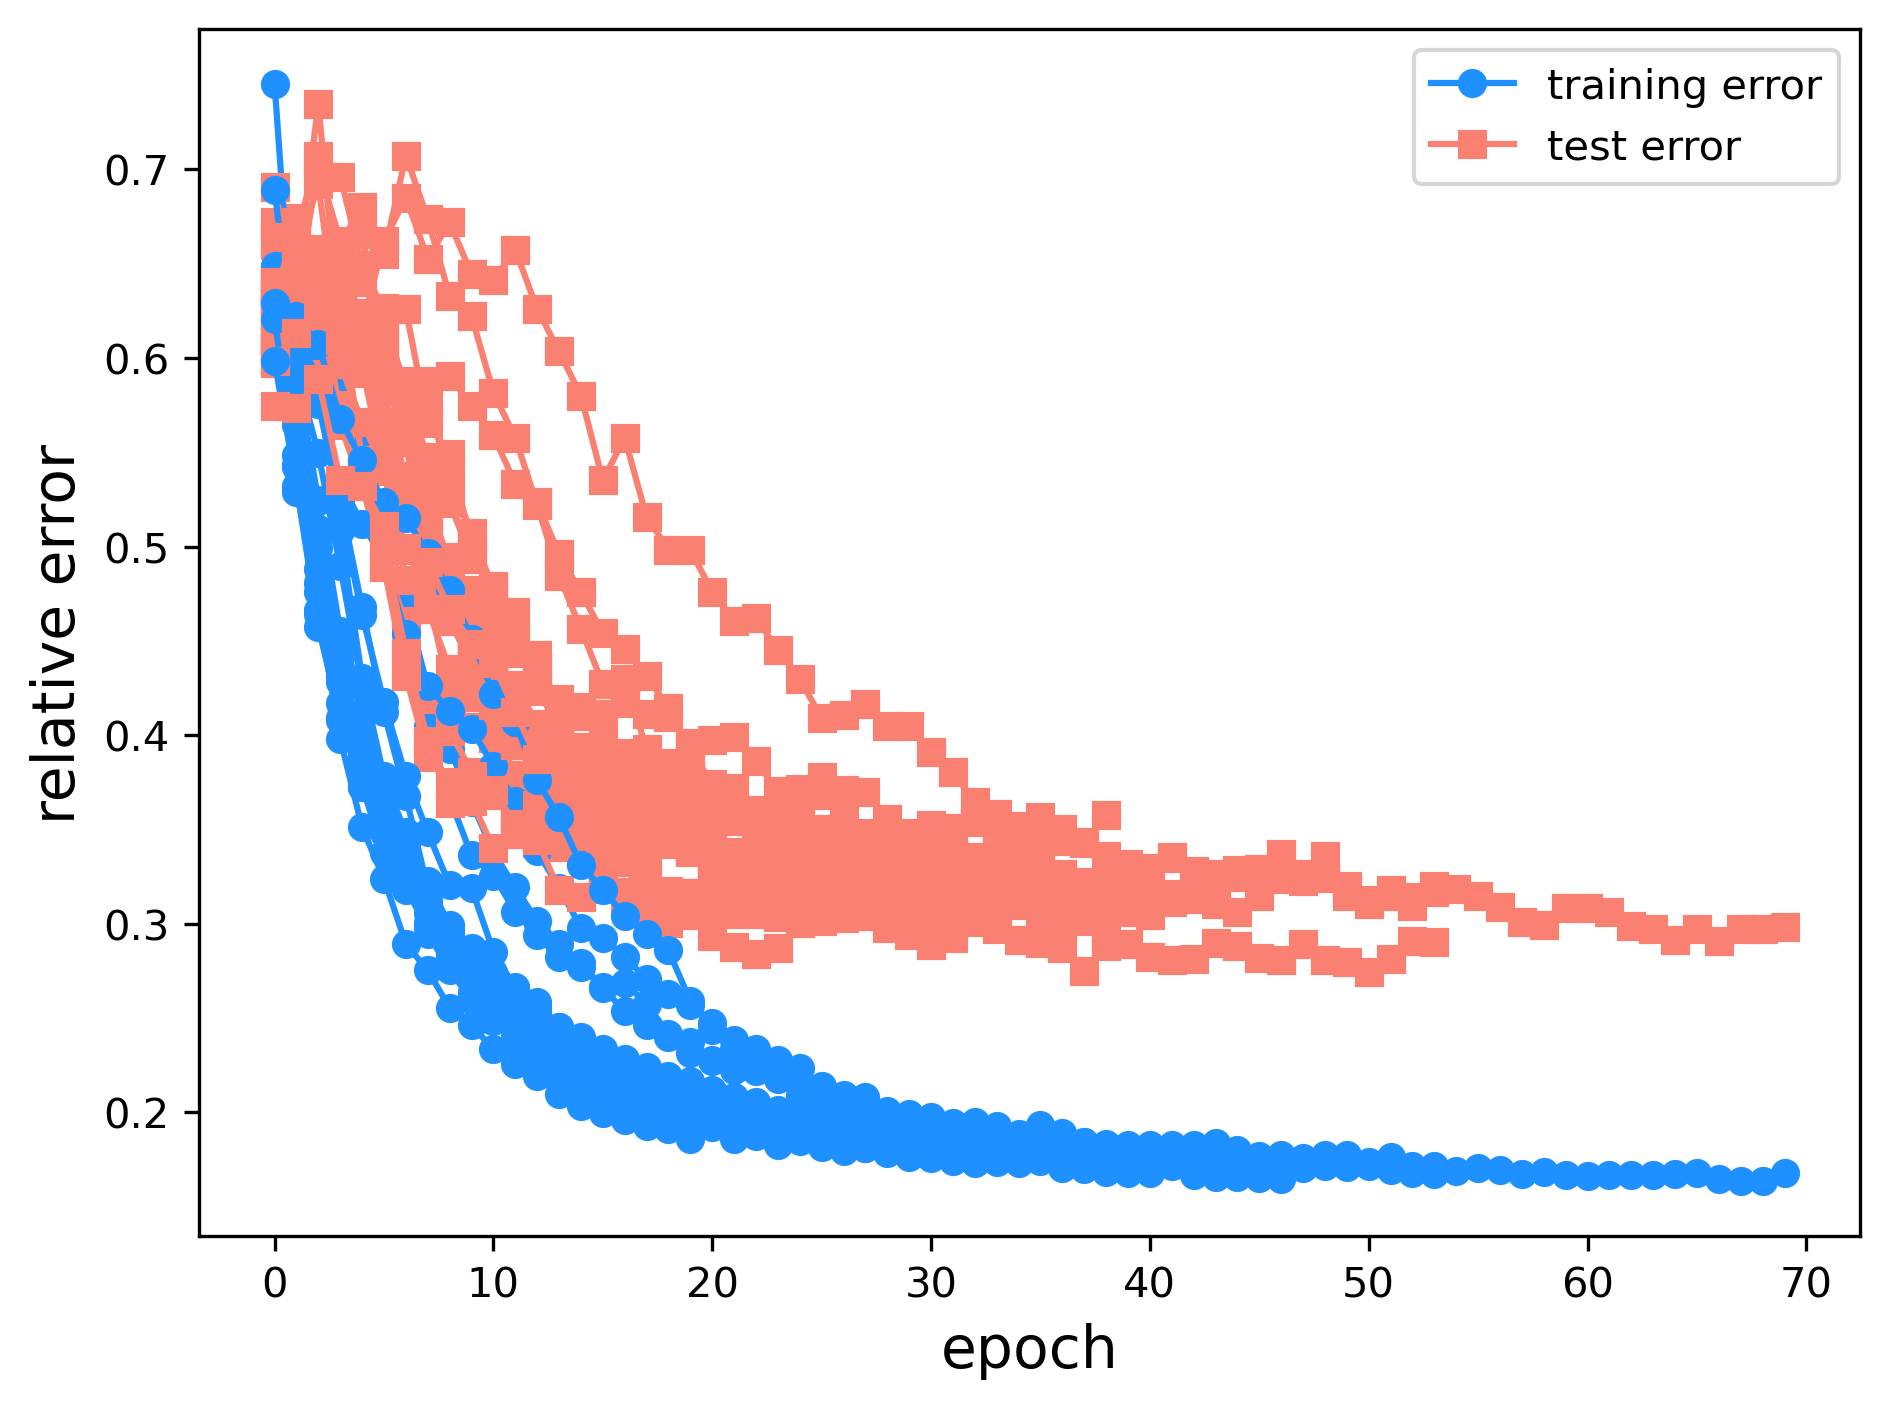

In [16]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


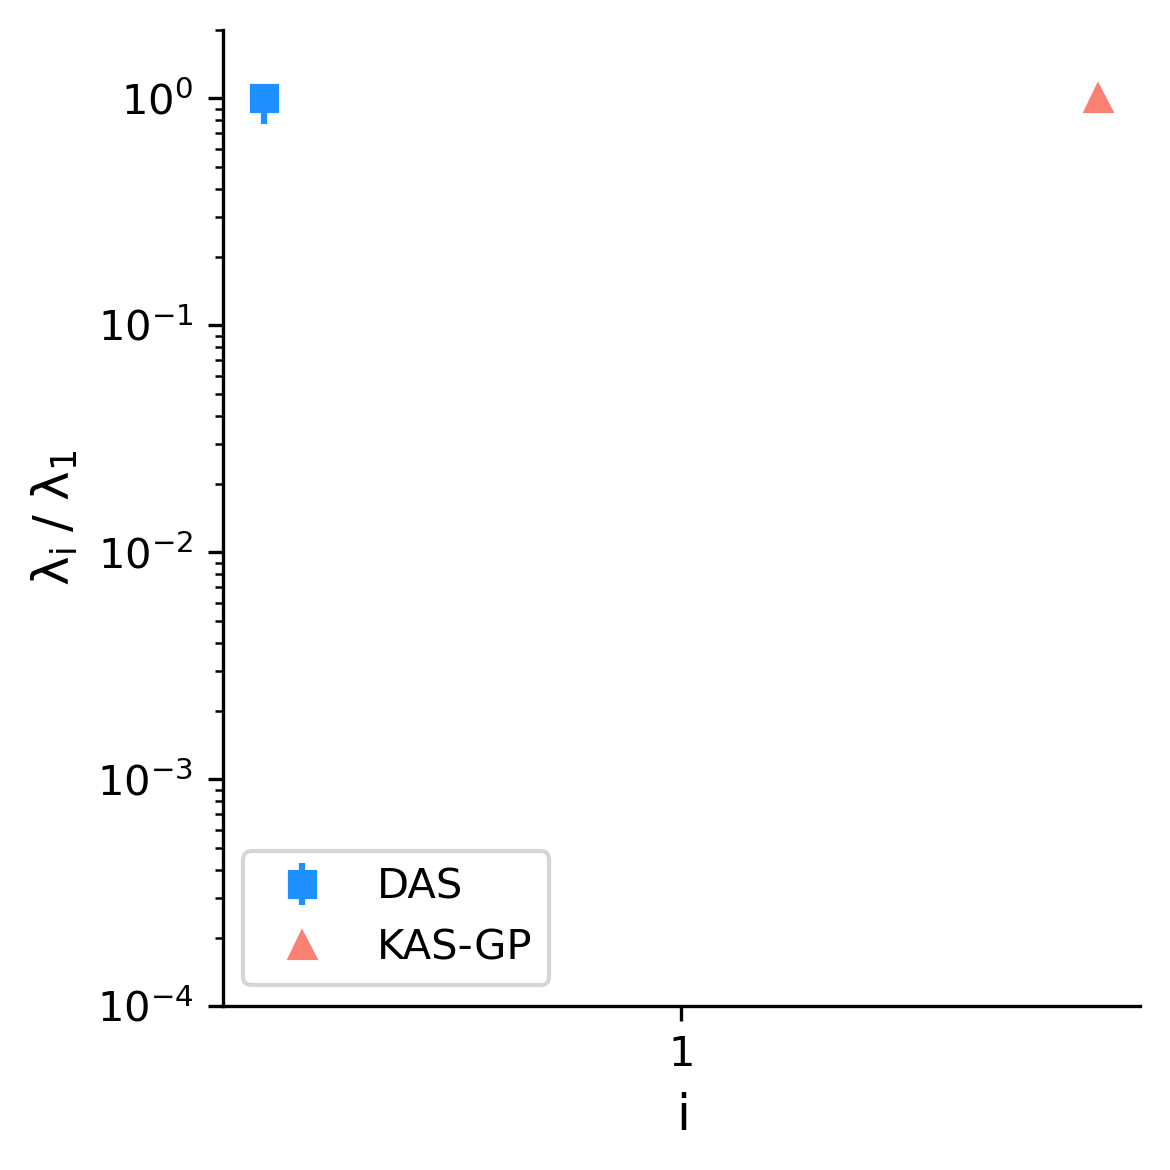

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_ties.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/ties_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the DAS surrogate a a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])


In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

### Recreate the active subspace plot

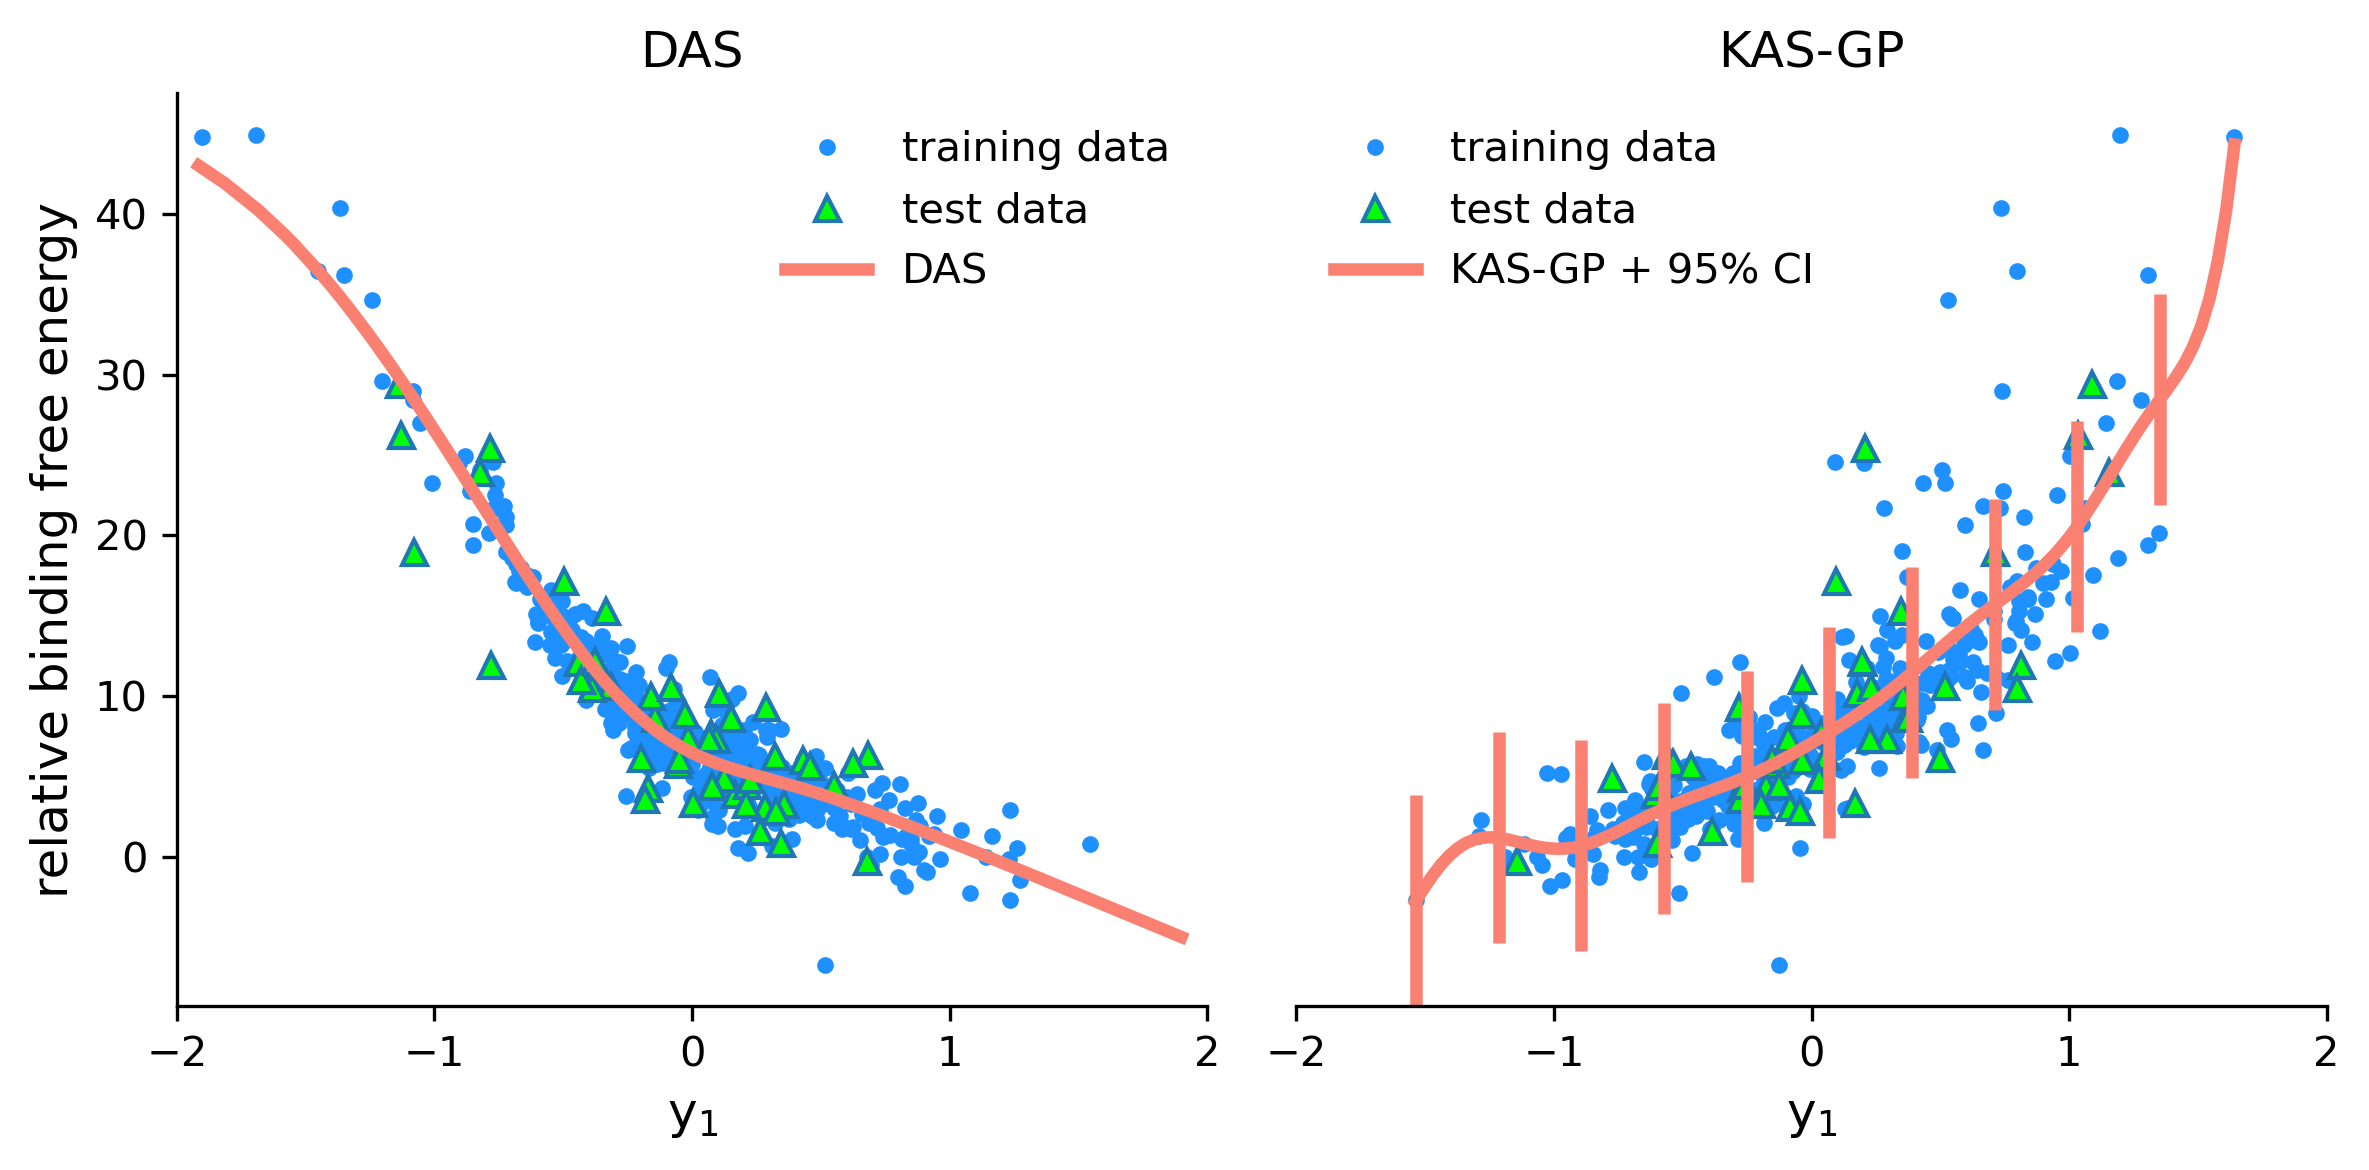

In [21]:
# QoI labels
lbl = {QoI: r'relative binding free energy'}

#########################
# plot active subspaces #
#########################
# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')    
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/ties_result.npy', allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/ties_surrogate_d%d.png' % (d, ))


### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_ties.csv')

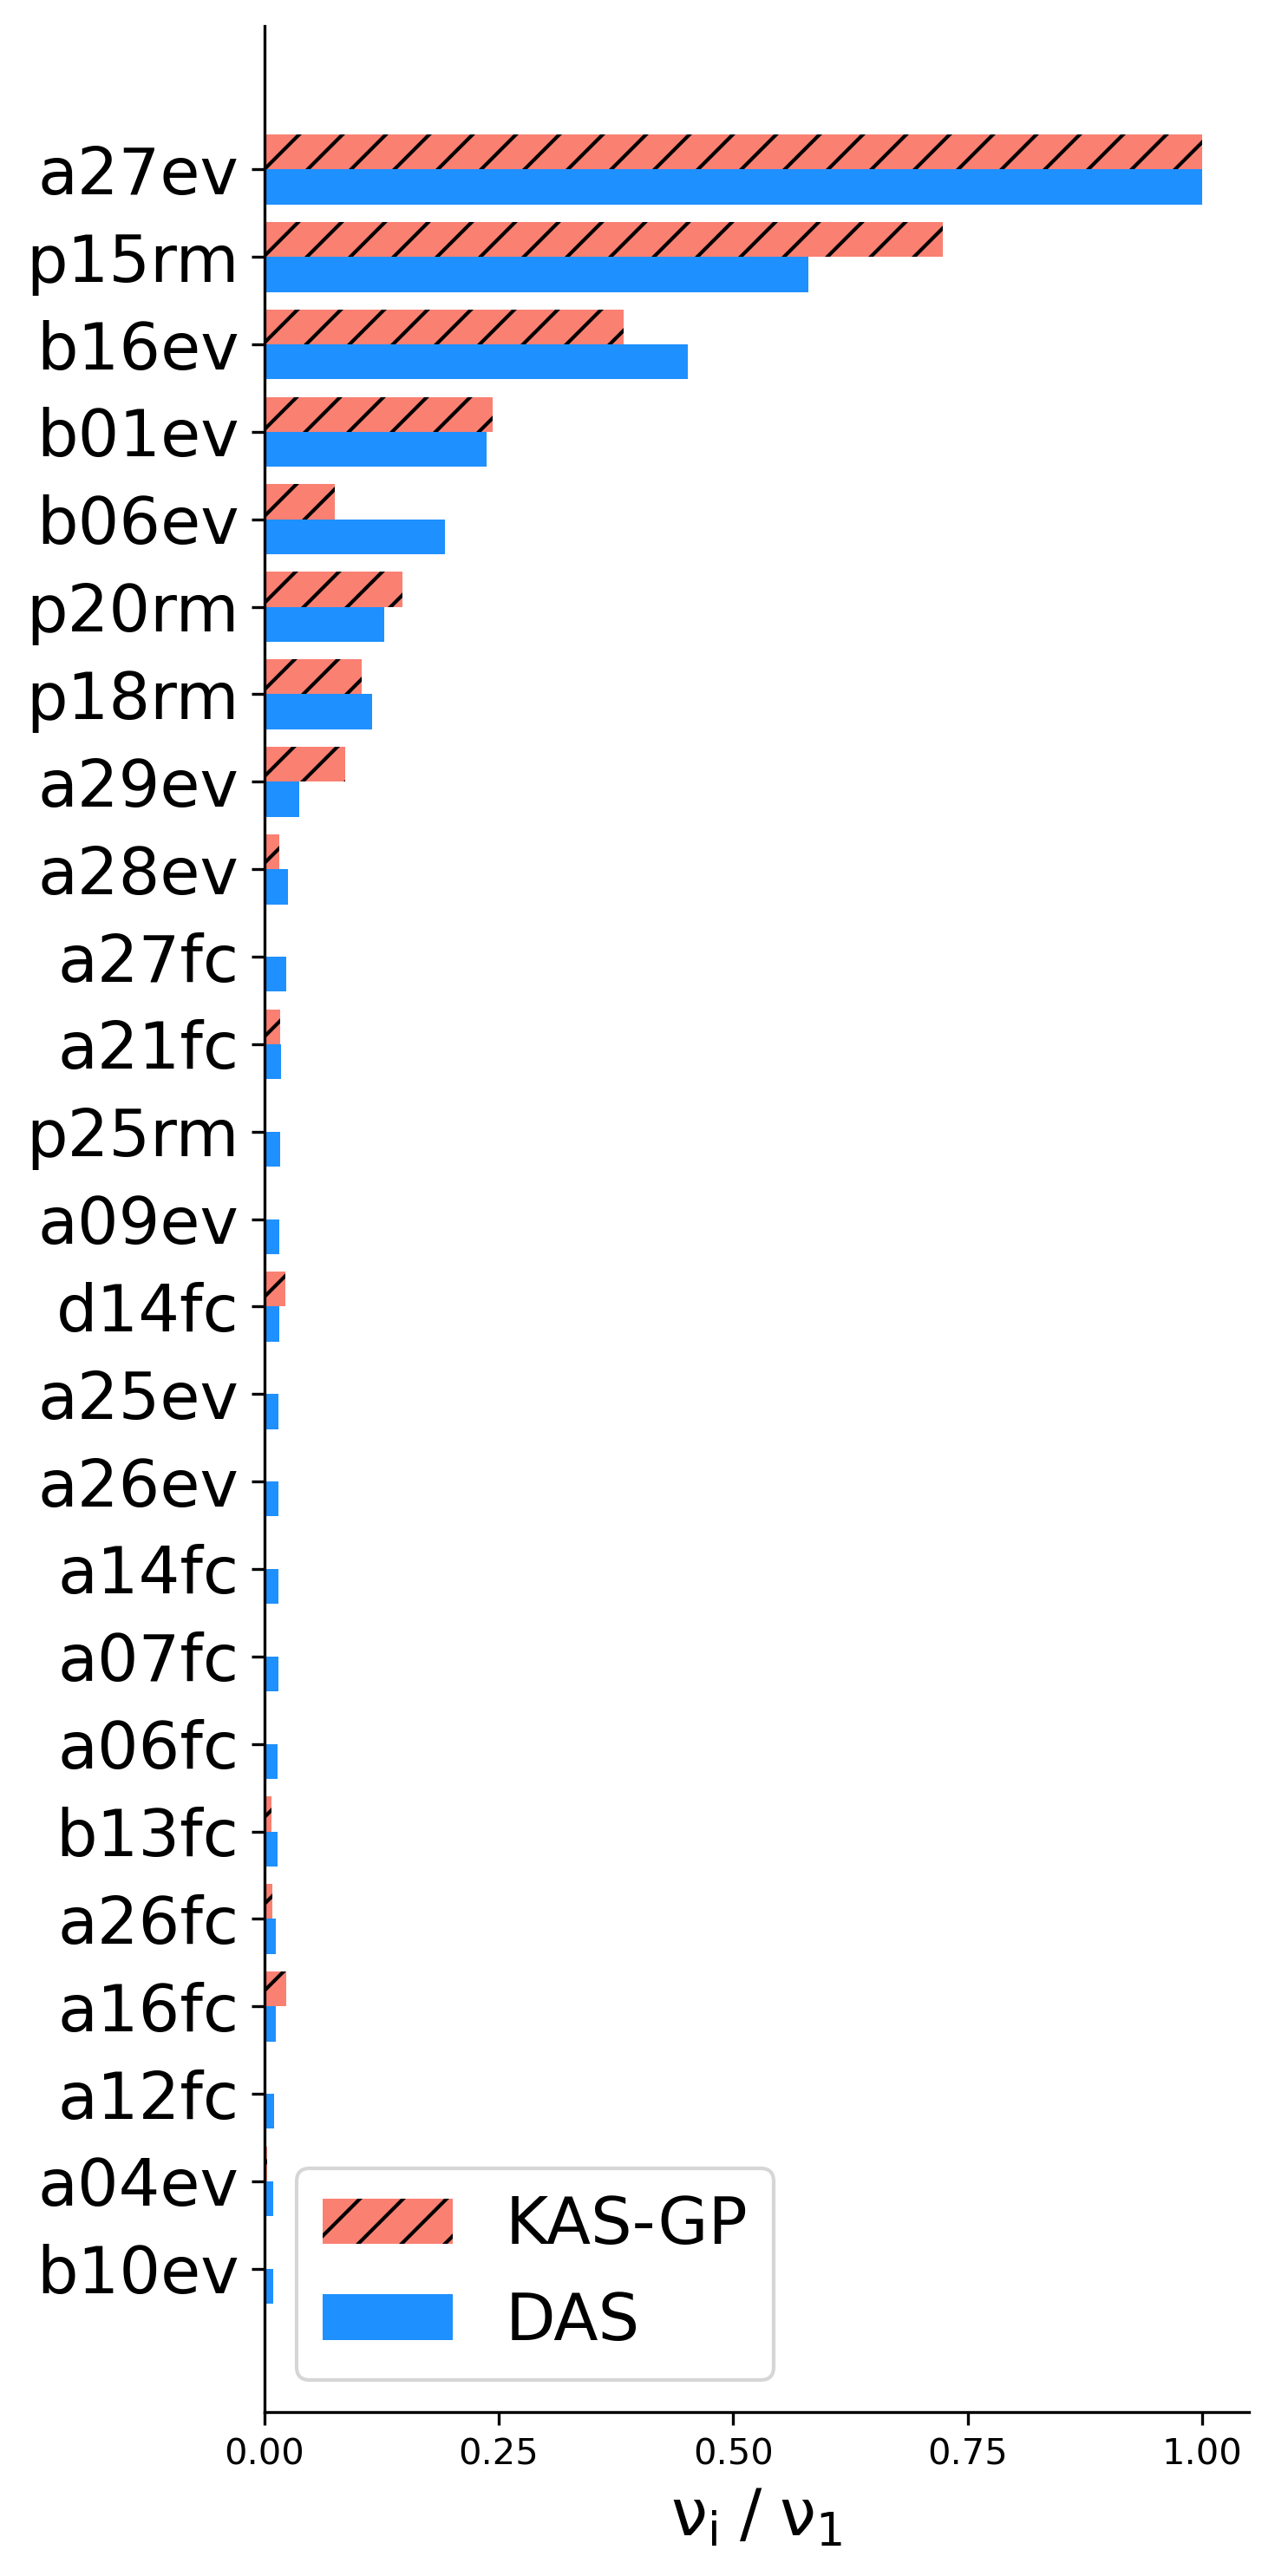

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


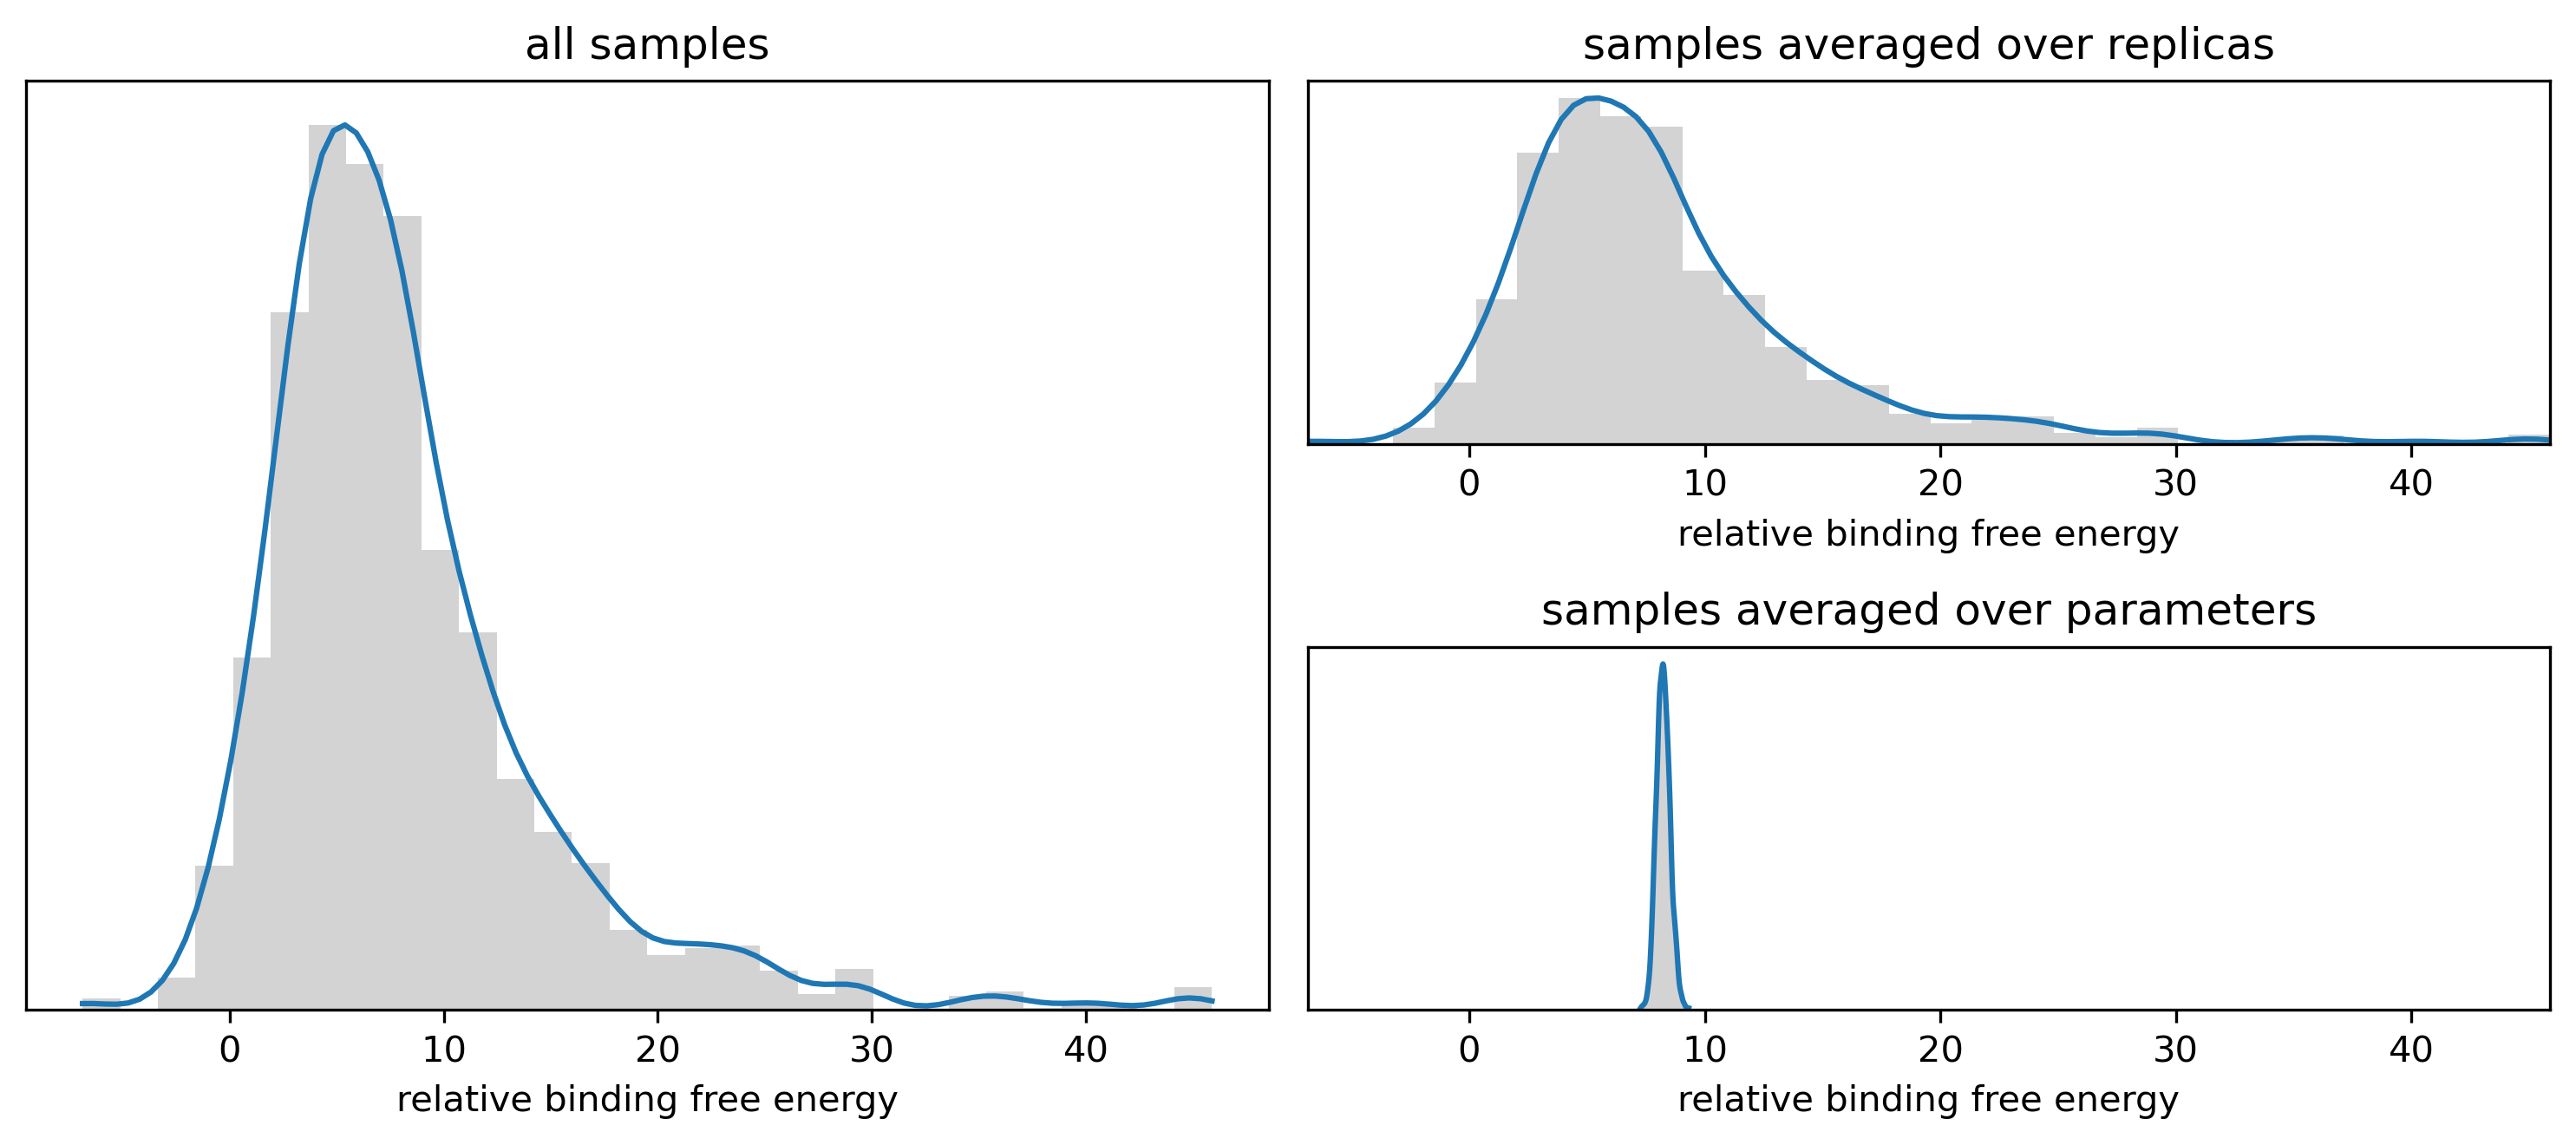

In [24]:
plot_dist(output, 'relative binding free energy')

### (Non-Gaussian) stats with bootstrapping

In [25]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:16<00:00, 733.89it/s]


In [26]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [27]:
print("Mean: %.2f (%.2f/%.2f)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2f (%.2f/%.2f)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.2f/%.2f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 8.23 (8.01/8.45)
Std dev: 6.70 (6.38/7.01)
Skew: 1.95 (1.77/2.11)
Kurt: 5.94 (4.91/6.87)
N_samples = 2440
